# 1. Importing Packages

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter


# 2. Loading Data

In [3]:
project_data = pd.read_csv('D:\\train_data.csv')
resource_data = pd.read_csv('D:\\resources.csv')

In [4]:
print("Number of data points in train data", project_data.shape)
print('='*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [5]:
print("Number of data points in resources data", resource_data.shape)
print(resource_data.columns.values)

Number of data points in resources data (1541272, 4)
['id' 'description' 'quantity' 'price']


In [6]:
resource_data.head()

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

In [7]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

In [8]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [9]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [10]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [11]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].replace(np.NaN,'Mrs.')

# 3. Text Preprocessing

# 3.1. Concatenating all essay text

In [12]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

# 3.2. Preprocessing Essay text

In [13]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[49999])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
sent = decontracted(project_data['essay'].values[16499])
print(sent)
print("="*50) 

I teach an amazing, energetic, engaged, and kind group of 5th grade students in an inner city high poverty public school in Indianapolis. Many of my students have parents who work odd hours and have limited time to spend with their wonderfully talented children. My students work hard in class giving 110% with everything that they do. They persevere through difficult topics, enjoy being engaged in their hands-on activities, and they love to laugh while learning. I set high expectation for my students. They understand that true, authentic learning takes hard work, dedication, and requires them to take ownership over their education. My goal for my students is to leave my class as life long learners. The students work hard to overcome all obstacles in their path to meet and grow past my expectations.My students love being active while they are learning and wiggling while they are working. I am lucky enough to have one Hokki stools in my classroom. Sadly, one is not enough to reach all my 

In [16]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

I teach an amazing, energetic, engaged, and kind group of 5th grade students in an inner city high poverty public school in Indianapolis. Many of my students have parents who work odd hours and have limited time to spend with their wonderfully talented children. My students work hard in class giving 110% with everything that they do. They persevere through difficult topics, enjoy being engaged in their hands-on activities, and they love to laugh while learning. I set high expectation for my students. They understand that true, authentic learning takes hard work, dedication, and requires them to take ownership over their education. My goal for my students is to leave my class as life long learners. The students work hard to overcome all obstacles in their path to meet and grow past my expectations.My students love being active while they are learning and wiggling while they are working. I am lucky enough to have one Hokki stools in my classroom. Sadly, one is not enough to reach all my 

In [17]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

I teach an amazing energetic engaged and kind group of 5th grade students in an inner city high poverty public school in Indianapolis Many of my students have parents who work odd hours and have limited time to spend with their wonderfully talented children My students work hard in class giving 110 with everything that they do They persevere through difficult topics enjoy being engaged in their hands on activities and they love to laugh while learning I set high expectation for my students They understand that true authentic learning takes hard work dedication and requires them to take ownership over their education My goal for my students is to leave my class as life long learners The students work hard to overcome all obstacles in their path to meet and grow past my expectations My students love being active while they are learning and wiggling while they are working I am lucky enough to have one Hokki stools in my classroom Sadly one is not enough to reach all my students My student

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [19]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = sent.lower()
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.strip())

100%|████████████████████████████████████████████████████████████████████████| 109248/109248 [01:36<00:00, 1131.48it/s]


In [20]:
# after preprocesing
preprocessed_essays[20000]

'kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism eager beavers always strive work hardest working past limitations materials ones seek students teach title school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore ever felt like ants pants needed groove move meeting kids feel time want able move learn say wobble chairs answer love develop core enhances gross motor turn fine motor skills also want learn games kids not want sit worksheets want learn count jumping playing physical engagement key success number toss color shape mats make happen students forget work fun 6 year old deserves nannan'

In [21]:
project_data['preprocessed_essays'] = preprocessed_essays 
project_data.drop(['essay'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  
0        23  students english learners working english seco...  
1         1  students arrive school eager learn polite gene...

# 3.2.1. Counting number of words in the combine essays

In [22]:
essay_count = []
for word in project_data['preprocessed_essays']:
    a = len(word.split())
    b = str(a)
    essay_count.append(b)

In [23]:
essay_count[20000]

'112'

In [24]:
project_data['number_of_words_in_essays'] = essay_count 
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  ...  \
0  Educational Support for English Learners at Home  ...   
1             Wanted: Projector for Hungry Learners  ...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                            0                    0  154.6   
1                                            7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

  number_of_words_in_essays  
0                       149  
1                        99  

[2 rows x 21 columns]

# 3.3. Preprocessing Title text

In [25]:
# printing some random essays.
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])
print("="*50)
print(project_data['project_title'].values[20000])
print("="*50)
print(project_data['project_title'].values[49999])
print("="*50)

Educational Support for English Learners at Home
More Movement with Hokki Stools
Sailing Into a Super 4th Grade Year
We Need To Move It While We Input It!
Inspiring Young Authors Through Reading


In [26]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [27]:
title = decontracted(project_data['project_title'].values[20000])
print(title)
print("="*50)

We Need To Move It While We Input It!


In [28]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
title = title.replace('\\r', ' ')
title = title.replace('\\"', ' ')
title = title.replace('\\n', ' ')
print(title)

We Need To Move It While We Input It!


In [29]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
title = re.sub('[^A-Za-z0-9]+', ' ', title)
print(title)

We Need To Move It While We Input It 


In [30]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [31]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for t in tqdm(project_data['project_title'].values):
    title = decontracted(t)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    # https://gist.github.com/sebleier/554280
    title = title.lower()
    title = ' '.join(e for e in title.split() if e not in stopwords)
    preprocessed_titles.append(title.strip())

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:04<00:00, 24758.84it/s]


In [32]:
# after preprocesing
preprocessed_titles[20000]

'need move input'

In [33]:
project_data['preprocessed_titles'] = preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                     project_essay_1  ... project_essay_3  \
0  My students are English learners that are work...  ...             NaN   
1  Our students arrive to our school eager to lea...  ...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                            0                    0  154.6   
1                                            7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

  number_of_words_in_essays                        preprocessed_titles  
0                       149  educational support english learners home  
1                        99           wanted projector hungry learners  

[2 rows x 21 columns]

# 3.3.1. Counting number of words in the title

In [34]:
title_count = []
for word in project_data['preprocessed_titles']:
    a = len(word.split())
    b = str(a)
    title_count.append(b)

In [35]:
title_count[20000]

'3'

In [36]:
project_data['number_of_words_in_the_title'] = title_count
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                     project_essay_1  ... project_essay_4  \
0  My students are English learners that are work...  ...             NaN   
1  Our students arrive to our school eager to lea...  ...             NaN   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects project_is_approved  price  \
0                                            0                   0  154.6   
1                                            7                   1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

   number_of_words_in_essays                        preprocessed_titles  \
0                        149  educational support english learners home   
1                         99           wanted projector hungry learners   

  number_of_words_in_the_title  
0                            5  
1                            4  

[2 rows x 22 columns]

# 3.4. Preprocessing project_grade_category

In [37]:
project_grade_clean_category = []

for i in range(len(project_data)):
    a = project_data["project_grade_category"][i].replace(" ", "_").replace("-","_")
    project_grade_clean_category.append(a)

In [38]:
project_grade_clean_category[0:5]

['Grades_PreK_2', 'Grades_6_8', 'Grades_6_8', 'Grades_PreK_2', 'Grades_PreK_2']

In [39]:
project_data['project_grade_clean_category'] = project_grade_clean_category 
project_data.drop(['project_grade_category'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime         project_subject_categories  \
0           IN        2016-12-05 13:43:57                Literacy & Language   
1           FL        2016-10-25 09:22:10  History & Civics, Health & Sports   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ...  \
0  \"The limits of your language are the limits o...  ...   
1  The projector we need for our school is very c...  ...   

                            project_resource_summary  \
0  My students need opportunities to practice beg...   
1  My students need a projector to help with view...   

  teacher_number_of_previously_posted_projects project_is_approved  price  \
0                                            0                   0  154.6   
1                                            7                   1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

   number_of_words_in_essays                        preprocessed_titles  \
0                        149  educational support english learners home   
1                         99           wanted projector hungry learners   

  number_of_words_in_the_title project_grade_clean_category  
0                            5                Grades_PreK_2  
1                            4                   Grades_6_8  

[2 rows x 22 columns]

# 3.5. Preprocessing project_subject_categories

In [40]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [41]:
cat_list[0:5]

['Literacy_Language',
 'History_Civics Health_Sports',
 'Health_Sports',
 'Literacy_Language Math_Science',
 'Math_Science']

In [42]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime     project_subject_subcategories  \
0           IN        2016-12-05 13:43:57                     ESL, Literacy   
1           FL        2016-10-25 09:22:10  Civics & Government, Team Sports   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  ...  \
0  \"The limits of your language are the limits o...             NaN  ...   
1  The projector we need for our school is very c...             NaN  ...   

  teacher_number_of_previously_posted_projects project_is_approved  price  \
0                                            0                   0  154.6   
1                                            7                   1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

   number_of_words_in_essays                        preprocessed_titles  \
0                        149  educational support english learners home   
1                         99           wanted projector hungry learners   

  number_of_words_in_the_title project_grade_clean_category  \
0                            5                Grades_PreK_2   
1                            4                   Grades_6_8   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports  

[2 rows x 22 columns]

# 3.6. Preprocessing project_subject_subcategories

In [43]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [44]:
sub_cat_list[0:5]

['ESL Literacy',
 'Civics_Government TeamSports',
 'Health_Wellness TeamSports',
 'Literacy Mathematics',
 'Mathematics']

In [45]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime  \
0           IN        2016-12-05 13:43:57   
1           FL        2016-10-25 09:22:10   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4  ... project_is_approved  price  quantity  \
0             NaN  ...                   0  154.6        23   
1             NaN  ...                   1  299.0         1   

                                 preprocessed_essays  \
0  students english learners working english seco...   
1  students arrive school eager learn polite gene...   

   number_of_words_in_essays                        preprocessed_titles  \
0                        149  educational support english learners home   
1                         99           wanted projector hungry learners   

  number_of_words_in_the_title project_grade_clean_category  \
0                            5                Grades_PreK_2   
1                            4                   Grades_6_8   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports  

[2 rows x 22 columns]

In [46]:
project_data.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime  \
0           IN        2016-12-05 13:43:57   
1           FL        2016-10-25 09:22:10   
2           AZ        2016-08-31 12:03:56   
3           KY        2016-10-06 21:16:17   
4           TX        2016-07-11 01:10:09   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4  ... project_is_approved   price  quantity  \
0             NaN  ...                   0  154.60        23   
1             NaN  ...                   1  299.00         1   
2             NaN  ...                   0  516.85        22   
3             NaN  ...                   1  232.90         4   
4             NaN  ...                   1   67.98         4   

                                 preprocessed_essays  \
0  students english learners working english seco...   
1  students arrive school eager learn polite gene...   
2  true champions not always ones win guts mia ha...   
3  work unique school filled esl english second l...   
4  second grade classroom next year made around 2...   

   number_of_words_in_essays                              preprocessed_titles  \
0                        149        educational support english learners home   
1                         99                 wanted projector hungry learners   
2                        188  soccer equipment awesome middle school students   
3                        112                           techie kindergarteners   
4                        112                           interactive math tools   

  number_of_words_in_the_title project_grade_clean_category  \
0                            5                Grades_PreK_2   
1                            4                   Grades_6_8   
2                            6                   Grades_6_8   
3                            2                Grades_PreK_2   
4                            3                Grades_PreK_2   

                 clean_categories           clean_subcategories  
0               Literacy_Language                  ESL Literacy  
1    History_Civics Health_Sports  Civics_Government TeamSports  
2                   Health_Sports    Health_Wellness TeamSports  
3  Literacy_Language Math_Science          Literacy Mathematics  
4                    Math_Science                   Mathematics  

[5 rows x 22 columns]

# 4. Sentiment score's of each of the essay

In [47]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [48]:
analyser = SentimentIntensityAnalyzer()

In [49]:
neg = []
pos = []
neu = []
compound = []

for a in tqdm(project_data["preprocessed_essays"]) :
    b = analyser.polarity_scores(a)['neg']
    c = analyser.polarity_scores(a)['pos']
    d = analyser.polarity_scores(a)['neu']
    e = analyser.polarity_scores(a)['compound']
    neg.append(b)
    pos.append(c)
    neu.append(d)
    compound.append(e)

100%|██████████████████████████████████████████████████████████████████████████| 109248/109248 [20:08<00:00, 90.38it/s]


In [50]:
project_data["pos"] = pos

In [51]:
project_data["neg"] = neg

In [52]:
project_data["neu"] = neu

In [53]:
project_data["compound"] = compound

In [54]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime  \
0           IN        2016-12-05 13:43:57   
1           FL        2016-10-25 09:22:10   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4  ... number_of_words_in_essays  \
0             NaN  ...                       149   
1             NaN  ...                        99   

                         preprocessed_titles  number_of_words_in_the_title  \
0  educational support english learners home                             5   
1           wanted projector hungry learners                             4   

   project_grade_clean_category              clean_categories  \
0                 Grades_PreK_2             Literacy_Language   
1                    Grades_6_8  History_Civics Health_Sports   

            clean_subcategories    pos    neg    neu compound  
0                  ESL Literacy  0.154  0.013  0.833   0.9694  
1  Civics_Government TeamSports  0.305  0.052  0.643   0.9856  

[2 rows x 26 columns]

# 5. Splitting data into Train and cross validation(or test): Stratified Sampling

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(project_data, project_data['project_is_approved'], test_size=0.33, stratify = project_data['project_is_approved'])
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

# 6. Dropping Target values from Train, Test and CV set

In [56]:
X_train.drop(['project_is_approved'], axis=1, inplace=True)
X_test.drop(['project_is_approved'], axis=1, inplace=True)
X_cv.drop(['project_is_approved'], axis=1, inplace=True)

In [57]:
print(X_train.shape)
print(X_test.shape)
print(X_cv.shape)

(49041, 25)
(36052, 25)
(24155, 25)


In [58]:
X_train.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
74256      167247  p157147  9e2e9b636c10d12e91e2daa9715b989f            Ms.   
18907      119402  p001440  344b01f27068c2047f3facfb2a8b58b2           Mrs.   

      school_state project_submitted_datetime  \
74256           NJ        2017-02-21 08:02:30   
18907           IL        2017-01-08 17:43:27   

                                         project_essay_1  \
74256  Our 4th grade inclusion classroom is filled wi...   
18907  Jasper County Junior High students love to do ...   

                                         project_essay_2 project_essay_3  \
74256  By the time students reach the 4th grade, the ...             NaN   
18907  Jasper County Junior High holds an annual loca...             NaN   

      project_essay_4  ... number_of_words_in_essays  \
74256             NaN  ...                       192   
18907             NaN  ...                       150   

                                     preprocessed_titles  \
74256                        launch lego learning part 3   
18907  jasper county junior high annual local science...   

       number_of_words_in_the_title  project_grade_clean_category  \
74256                             5                    Grades_3_5   
18907                             8                    Grades_6_8   

                       clean_categories                   clean_subcategories  \
74256  History_Civics Literacy_Language  History_Geography Literature_Writing   
18907                      Math_Science    AppliedSciences Health_LifeScience   

         pos    neg    neu compound  
74256  0.246  0.021  0.733   0.9919  
18907  0.369  0.065  0.566   0.9960  

[2 rows x 25 columns]

In [59]:
y_train.head()

74256    1
18907    1
90972    1
61993    0
59817    1
Name: project_is_approved, dtype: int64

# 7. Encoding Categorical Data

# 7.1. One Hot Encoding of clean_categories

In [60]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['clean_categories'].values:
#     my_counter.update(word.split())

# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# cat_dict = dict(my_counter)
# sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

In [61]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(lowercase=False, binary=True)
vectorizer1.fit(X_train['clean_categories'].values)
print(vectorizer1.get_feature_names())


categories_one_hot_Xtrain = vectorizer1.transform(X_train['clean_categories'].values)
categories_one_hot_Xtest = vectorizer1.transform(X_test['clean_categories'].values)
categories_one_hot_Xcv = vectorizer1.transform(X_cv['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encodig ",categories_one_hot_Xtest.shape)
print("Shape of matrix after one hot encodig ",categories_one_hot_Xcv.shape)

['AppliedLearning', 'Care_Hunger', 'Health_Sports', 'History_Civics', 'Literacy_Language', 'Math_Science', 'Music_Arts', 'SpecialNeeds', 'Warmth']
Shape of matrix after one hot encodig  (49041, 9)
Shape of matrix after one hot encodig  (36052, 9)
Shape of matrix after one hot encodig  (24155, 9)


# 7.2. One Hot Encoding of clean_subcategories

In [62]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['clean_subcategories'].values:
#     my_counter.update(word.split())

# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# sub_cat_dict = dict(my_counter)
# sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [63]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer2 = CountVectorizer(lowercase=False, binary=True)
vectorizer2.fit(project_data['clean_subcategories'].values)
print(vectorizer2.get_feature_names())


sub_categories_one_hot_Xtrain = vectorizer2.transform(X_train['clean_subcategories'].values)
sub_categories_one_hot_Xtest = vectorizer2.transform(X_test['clean_subcategories'].values)
sub_categories_one_hot_Xcv = vectorizer2.transform(X_cv['clean_subcategories'].values)

print("Shape of matrix after one hot encoding ",sub_categories_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot_Xtest.shape)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot_Xcv.shape)

['AppliedSciences', 'Care_Hunger', 'CharacterEducation', 'Civics_Government', 'College_CareerPrep', 'CommunityService', 'ESL', 'EarlyDevelopment', 'Economics', 'EnvironmentalScience', 'Extracurricular', 'FinancialLiteracy', 'ForeignLanguages', 'Gym_Fitness', 'Health_LifeScience', 'Health_Wellness', 'History_Geography', 'Literacy', 'Literature_Writing', 'Mathematics', 'Music', 'NutritionEducation', 'Other', 'ParentInvolvement', 'PerformingArts', 'SocialSciences', 'SpecialNeeds', 'TeamSports', 'VisualArts', 'Warmth']
Shape of matrix after one hot encoding  (49041, 30)
Shape of matrix after one hot encodig  (36052, 30)
Shape of matrix after one hot encodig  (24155, 30)


# 7.3. One Hot Encoding of school_state

In [64]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['school_state'].values:
#     my_counter.update(word.split())
    
# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# school_state_dict = dict(my_counter)
# sorted_school_state_dict = dict(sorted(school_state_dict.items(), key=lambda kv: kv[1]))

In [65]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer3 = CountVectorizer(lowercase=False, binary=True)
vectorizer3.fit(project_data['school_state'].values)
print(vectorizer3.get_feature_names())


school_state_one_hot_Xtrain = vectorizer3.transform(X_train['school_state'].values)
school_state_one_hot_Xtest = vectorizer3.transform(X_test['school_state'].values)
school_state_one_hot_Xcv = vectorizer3.transform(X_cv['school_state'].values)

print("Shape of matrix after one hot encoding ",school_state_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encoding ",school_state_one_hot_Xtest.shape)
print("Shape of matrix after one hot encoding ",school_state_one_hot_Xcv.shape)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of matrix after one hot encoding  (49041, 51)
Shape of matrix after one hot encoding  (36052, 51)
Shape of matrix after one hot encoding  (24155, 51)


# 7.4. One Hot Encoding of teacher_prefix

In [66]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['teacher_prefix'].values:
#     my_counter.update(word.split())
    
# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# teacher_prefix_dict = dict(my_counter)
# sorted_teacher_prefix_dict = dict(sorted(teacher_prefix_dict.items(), key=lambda kv: kv[1]))

In [67]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer4 = CountVectorizer(lowercase=False, binary=True)
vectorizer4.fit(project_data['teacher_prefix'].values)
print(vectorizer4.get_feature_names())


teacher_prefix_one_hot_Xtrain = vectorizer4.transform(X_train['teacher_prefix'].values)
teacher_prefix_one_hot_Xtest = vectorizer4.transform(X_test['teacher_prefix'].values)
teacher_prefix_one_hot_Xcv = vectorizer4.transform(X_cv['teacher_prefix'].values)

print("Shape of matrix after one hot encoding ",teacher_prefix_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encoding ",teacher_prefix_one_hot_Xtest.shape)
print("Shape of matrix after one hot encoding ",teacher_prefix_one_hot_Xcv.shape)

['Dr', 'Mr', 'Mrs', 'Ms', 'Teacher']
Shape of matrix after one hot encoding  (49041, 5)
Shape of matrix after one hot encoding  (36052, 5)
Shape of matrix after one hot encoding  (24155, 5)


# 7.5. One Hot Encoding of project_grade_clean_category

In [68]:
# # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
# from collections import Counter
# my_counter = Counter()
# for word in project_data['project_grade_clean_category'].values:
#     my_counter.update(word.split())
    
# # dict sort by value python: https://stackoverflow.com/a/613218/4084039
# grade_dict = dict(my_counter)
# sorted_grade_dict = dict(sorted(grade_dict.items(), key=lambda kv: kv[1]))

In [69]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer5 = CountVectorizer(lowercase=False, binary=True)
vectorizer5.fit(project_data['project_grade_clean_category'].values)
print(vectorizer5.get_feature_names())


grade_one_hot_Xtrain = vectorizer5.transform(X_train['project_grade_clean_category'].values)
grade_one_hot_Xtest = vectorizer5.transform(X_test['project_grade_clean_category'].values)
grade_one_hot_Xcv = vectorizer5.transform(X_cv['project_grade_clean_category'].values)

print("Shape of matrix after one hot encoding ",grade_one_hot_Xtrain.shape)
print("Shape of matrix after one hot encoding ",grade_one_hot_Xtest.shape)
print("Shape of matrix after one hot encoding ",grade_one_hot_Xcv.shape)

['Grades_3_5', 'Grades_6_8', 'Grades_9_12', 'Grades_PreK_2']
Shape of matrix after one hot encoding  (49041, 4)
Shape of matrix after one hot encoding  (36052, 4)
Shape of matrix after one hot encoding  (24155, 4)


# 8. Encoding of Text Data

# 8.1.1. BOW encoding of preprocessed_essays

In [70]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer6 = CountVectorizer(min_df=10)
text_bow_Xtrain = vectorizer6.fit_transform(X_train['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_bow_Xtrain.shape)
text_bow_Xtest = vectorizer6.transform(X_test['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_bow_Xtest.shape)
text_bow_Xcv = vectorizer6.transform(X_cv['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_bow_Xcv.shape)

Shape of matrix after one hot encodig  (49041, 12030)
Shape of matrix after one hot encodig  (36052, 12030)
Shape of matrix after one hot encodig  (24155, 12030)


# 8.1.2. BOW encoding of preprocessed_titles

In [71]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer7 = CountVectorizer(min_df=10)
title_bow_Xtrain = vectorizer7.fit_transform(X_train['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_bow_Xtrain.shape)
title_bow_Xtest = vectorizer7.transform(X_test['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_bow_Xtest.shape)
title_bow_Xcv = vectorizer7.transform(X_cv['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_bow_Xcv.shape)

Shape of matrix after one hot encodig  (49041, 2016)
Shape of matrix after one hot encodig  (36052, 2016)
Shape of matrix after one hot encodig  (24155, 2016)


# 8.2.1. TFIDF encoding of preprocessed_essays

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer8 = TfidfVectorizer(min_df=10)
text_tfidf_Xtrain = vectorizer8.fit_transform(X_train['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_tfidf_Xtrain.shape)
text_tfidf_Xtest = vectorizer8.transform(X_test['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_tfidf_Xtest.shape)
text_tfidf_Xcv = vectorizer8.transform(X_cv['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_tfidf_Xcv.shape)

Shape of matrix after one hot encodig  (49041, 12030)
Shape of matrix after one hot encodig  (36052, 12030)
Shape of matrix after one hot encodig  (24155, 12030)


# Using elbow method to find n_components for truncated SVD

In [83]:
X = text_tfidf_Xtrain[:,0:3000]    # Due to memory isssue
Y= text_tfidf_Xtest[:,0:3000]
Z= text_tfidf_Xcv[:,0:3000]

In [84]:
print(X.shape)
print(Y.shape)
print(Z.shape)

(49041, 3000)
(36052, 3000)
(24155, 3000)


In [75]:
from sklearn.decomposition import TruncatedSVD
feature_number = [100,400,800,1200,2000]
Variance_sum = []
for i in tqdm(feature_number):
    svd = TruncatedSVD(n_components = i , random_state = 42)
    svd.fit(X)
    Variance_sum.append(svd.explained_variance_ratio_.sum())


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:39<00:00, 98.56s/it]

In [ ]:
# from sklearn.decomposition import TruncatedSVD
# #https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
# #declaring index as Dimensions in train_text_tfidf
# svd = TruncatedSVD(n_components = 2500, random_state = 42)
# svd.fit(X)
# Variance_sum.append(svd.explained_variance_ratio_.sum())

In [76]:
Variance_sum

[0.26027893183455386,
 0.5296091192140049,
 0.6933967121237589,
 0.7875106167036654,
 0.8915278107419001]

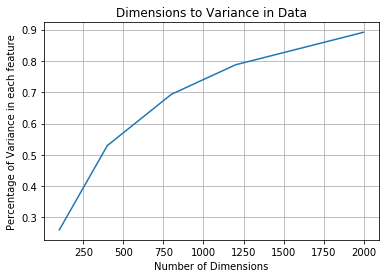

In [79]:
plt.xlabel("Number of Dimensions")
plt.ylabel("Percentage of Variance in each feature")
plt.title("Dimensions to Variance in Data")
plt.plot(feature_number,Variance_sum)
plt.grid(True)
plt.show()

In [85]:
svd = TruncatedSVD(n_components = 2000)
#Train SVD
svdtrain = svd.fit_transform(X)
#Test SVD
svdtest = svd.transform(Y)
#CV SVD
svdcv =  svd.transform(Z)

In [86]:
print(svdtrain.shape)
print(svdtest.shape)
print(svdcv.shape)

(49041, 2000)
(36052, 2000)
(24155, 2000)


# 8.2.2. TFIDF encoding of preprocessed_titles

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer9 = TfidfVectorizer(min_df=10)
title_tfidf_Xtrain = vectorizer9.fit_transform(X_train['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_tfidf_Xtrain.shape)
title_tfidf_Xtest = vectorizer9.transform(X_test['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_tfidf_Xtest.shape)
title_tfidf_Xcv = vectorizer9.transform(X_cv['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_tfidf_Xcv.shape)

Shape of matrix after one hot encodig  (49041, 2016)
Shape of matrix after one hot encodig  (36052, 2016)
Shape of matrix after one hot encodig  (24155, 2016)


# 8.3.1. Average Word2Vec encoding of preprocessed_essays on Train Data

In [89]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('D:\glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [217]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_essays_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essays_Xtrain.append(vector)

print(len(avg_w2v_vectors_essays_Xtrain))
print(len(avg_w2v_vectors_essays_Xtrain[2]))




  0%|                                                                                        | 0/49041 [00:00<?, ?it/s]


  0%|                                                                             | 1/49041 [00:02<40:11:26,  2.95s/it]


  0%|                                                                             | 2/49041 [00:04<33:16:13,  2.44s/it]


  0%|                                                                             | 3/49041 [00:05<27:57:54,  2.05s/it]


  0%|                                                                             | 4/49041 [00:06<23:37:45,  1.73s/it]


  0%|                                                                             | 5/49041 [00:07<19:58:24,  1.47s/it]


  0%|                                                                             | 6/49041 [00:07<16:18:18,  1.20s/it]


  0%|                                                                             | 7/49041 [00:08<13:09:31,  1.04it/s]


  0%|                

  1%|▊                                                                             | 548/49041 [00:31<14:50, 54.44it/s]


  1%|▉                                                                             | 554/49041 [00:31<15:11, 53.17it/s]


  1%|▉                                                                             | 560/49041 [00:31<14:57, 54.02it/s]


  1%|▉                                                                             | 569/49041 [00:31<14:01, 57.60it/s]


  1%|▉                                                                             | 575/49041 [00:31<14:06, 57.29it/s]


  1%|▉                                                                             | 581/49041 [00:31<15:38, 51.63it/s]


  1%|▉                                                                             | 587/49041 [00:32<16:28, 49.04it/s]


  1%|▉                                                                             | 597/49041 [00:32<14:05, 57.30it/s]


  1%|▉                  

  3%|██▌                                                                         | 1643/49041 [00:50<06:48, 116.04it/s]


  3%|██▌                                                                         | 1657/49041 [00:50<06:59, 113.07it/s]


  3%|██▌                                                                          | 1670/49041 [00:50<08:43, 90.57it/s]


  3%|██▋                                                                          | 1681/49041 [00:50<10:06, 78.10it/s]


  3%|██▋                                                                          | 1691/49041 [00:51<09:34, 82.47it/s]


  3%|██▋                                                                          | 1711/49041 [00:51<07:53, 99.98it/s]


  4%|██▋                                                                         | 1726/49041 [00:51<07:07, 110.73it/s]


  4%|██▋                                                                         | 1740/49041 [00:51<06:47, 116.06it/s]


  4%|██▋                

  7%|█████▍                                                                      | 3477/49041 [01:08<07:05, 107.04it/s]


  7%|█████▍                                                                      | 3497/49041 [01:08<06:14, 121.74it/s]


  7%|█████▌                                                                       | 3511/49041 [01:08<07:38, 99.33it/s]


  7%|█████▍                                                                      | 3525/49041 [01:08<07:01, 108.08it/s]


  7%|█████▍                                                                      | 3546/49041 [01:08<06:00, 126.27it/s]


  7%|█████▌                                                                      | 3561/49041 [01:08<06:27, 117.23it/s]


  7%|█████▌                                                                       | 3575/49041 [01:09<09:05, 83.32it/s]


  7%|█████▋                                                                       | 3586/49041 [01:09<09:11, 82.44it/s]


  7%|█████▋             

 11%|████████▎                                                                   | 5350/49041 [01:26<05:50, 124.68it/s]


 11%|████████▎                                                                   | 5365/49041 [01:26<06:28, 112.29it/s]


 11%|████████▎                                                                   | 5382/49041 [01:26<05:49, 124.76it/s]


 11%|████████▎                                                                   | 5397/49041 [01:26<06:07, 118.89it/s]


 11%|████████▍                                                                   | 5411/49041 [01:26<06:18, 115.15it/s]


 11%|████████▍                                                                   | 5424/49041 [01:26<07:12, 100.86it/s]


 11%|████████▌                                                                    | 5435/49041 [01:26<07:39, 94.85it/s]


 11%|████████▌                                                                    | 5446/49041 [01:27<08:03, 90.20it/s]


 11%|████████▍          

 16%|████████████                                                                | 7760/49041 [01:43<03:16, 210.50it/s]


 16%|████████████                                                                | 7783/49041 [01:43<03:38, 188.81it/s]


 16%|████████████                                                                | 7804/49041 [01:43<03:37, 189.37it/s]


 16%|████████████▏                                                               | 7825/49041 [01:43<04:00, 171.13it/s]


 16%|████████████▏                                                               | 7844/49041 [01:43<03:59, 172.17it/s]


 16%|████████████▏                                                               | 7872/49041 [01:43<03:33, 193.07it/s]


 16%|████████████▏                                                               | 7893/49041 [01:44<04:18, 159.28it/s]


 16%|████████████▎                                                               | 7911/49041 [01:44<04:19, 158.58it/s]


 16%|████████████▎      

 22%|████████████████▊                                                          | 11020/49041 [02:00<02:58, 213.21it/s]


 23%|████████████████▉                                                          | 11043/49041 [02:00<03:11, 198.20it/s]


 23%|████████████████▉                                                          | 11071/49041 [02:00<02:54, 217.12it/s]


 23%|████████████████▉                                                          | 11096/49041 [02:00<02:52, 219.51it/s]


 23%|█████████████████                                                          | 11119/49041 [02:00<02:56, 214.63it/s]


 23%|█████████████████                                                          | 11142/49041 [02:00<03:28, 181.76it/s]


 23%|█████████████████                                                          | 11162/49041 [02:01<03:28, 181.73it/s]


 23%|█████████████████                                                          | 11187/49041 [02:01<03:15, 193.38it/s]


 23%|█████████████████▏ 

 30%|██████████████████████▏                                                    | 14526/49041 [02:16<02:38, 218.35it/s]


 30%|██████████████████████▎                                                    | 14553/49041 [02:16<02:50, 202.57it/s]


 30%|██████████████████████▎                                                    | 14589/49041 [02:17<02:27, 232.88it/s]


 30%|██████████████████████▎                                                    | 14622/49041 [02:17<02:15, 254.88it/s]


 30%|██████████████████████▍                                                    | 14651/49041 [02:17<02:15, 253.34it/s]


 30%|██████████████████████▍                                                    | 14679/49041 [02:17<02:30, 228.86it/s]


 30%|██████████████████████▌                                                    | 14718/49041 [02:17<02:11, 260.82it/s]


 30%|██████████████████████▌                                                    | 14748/49041 [02:17<02:09, 265.73it/s]


 30%|███████████████████

 39%|█████████████████████████████▌                                             | 19361/49041 [02:33<01:50, 269.20it/s]


 40%|█████████████████████████████▋                                             | 19390/49041 [02:33<02:08, 230.01it/s]


 40%|█████████████████████████████▋                                             | 19424/49041 [02:33<01:57, 252.50it/s]


 40%|█████████████████████████████▋                                             | 19452/49041 [02:33<02:25, 203.95it/s]


 40%|█████████████████████████████▊                                             | 19476/49041 [02:34<02:31, 195.36it/s]


 40%|█████████████████████████████▊                                             | 19516/49041 [02:34<02:08, 230.40it/s]


 40%|█████████████████████████████▉                                             | 19547/49041 [02:34<01:58, 247.87it/s]


 40%|█████████████████████████████▉                                             | 19575/49041 [02:34<01:55, 254.05it/s]


 40%|███████████████████

 55%|█████████████████████████████████████████▍                                 | 27108/49041 [02:49<00:38, 572.30it/s]


 55%|█████████████████████████████████████████▌                                 | 27191/49041 [02:49<00:34, 629.73it/s]


 56%|█████████████████████████████████████████▊                                 | 27305/49041 [02:49<00:30, 717.87it/s]


 56%|█████████████████████████████████████████▉                                 | 27385/49041 [02:49<00:33, 650.54it/s]


 56%|█████████████████████████████████████████▉                                 | 27457/49041 [02:49<00:33, 647.73it/s]


 56%|██████████████████████████████████████████                                 | 27527/49041 [02:49<00:32, 660.97it/s]


 56%|██████████████████████████████████████████▏                                | 27597/49041 [02:50<00:36, 590.55it/s]


 56%|██████████████████████████████████████████▎                                | 27660/49041 [02:50<00:40, 530.82it/s]


 57%|███████████████████

 73%|██████████████████████████████████████████████████████▊                    | 35800/49041 [03:05<00:29, 452.19it/s]


 73%|██████████████████████████████████████████████████████▉                    | 35905/49041 [03:05<00:24, 533.75it/s]


 73%|███████████████████████████████████████████████████████                    | 35988/49041 [03:05<00:21, 596.54it/s]


 74%|███████████████████████████████████████████████████████▏                   | 36098/49041 [03:05<00:18, 688.94it/s]


 74%|███████████████████████████████████████████████████████▎                   | 36181/49041 [03:05<00:17, 724.20it/s]


 74%|███████████████████████████████████████████████████████▍                   | 36262/49041 [03:05<00:18, 690.65it/s]


 74%|███████████████████████████████████████████████████████▌                   | 36338/49041 [03:05<00:19, 637.42it/s]


 74%|███████████████████████████████████████████████████████▋                   | 36431/49041 [03:06<00:17, 702.34it/s]


 74%|███████████████████

 97%|████████████████████████████████████████████████████████████████████████▊  | 47649/49041 [03:20<00:01, 919.54it/s]


 97%|█████████████████████████████████████████████████████████████████████████  | 47751/49041 [03:20<00:01, 945.07it/s]


 98%|█████████████████████████████████████████████████████████████████████████▏ | 47850/49041 [03:21<00:01, 822.25it/s]


 98%|█████████████████████████████████████████████████████████████████████████▎ | 47938/49041 [03:21<00:01, 766.73it/s]


 98%|█████████████████████████████████████████████████████████████████████████▌ | 48063/49041 [03:21<00:01, 808.51it/s]


 98%|█████████████████████████████████████████████████████████████████████████▋ | 48183/49041 [03:21<00:00, 896.04it/s]


 98%|█████████████████████████████████████████████████████████████████████████▊ | 48297/49041 [03:21<00:00, 957.46it/s]


 99%|█████████████████████████████████████████████████████████████████████████ | 48429/49041 [03:21<00:00, 1041.12it/s]


 99%|███████████████████

49041
300


In [92]:
average_w2v_on_essay_Xtrain = np.vstack(avg_w2v_vectors_essays_Xtrain)
print(average_w2v_on_essay_Xtrain.shape)

(49041, 300)


# 8.3.2. Average Word2Vec encoding of preprocessed_essays on Test Data

In [93]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_essays_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essays_Xtest.append(vector)

print(len(avg_w2v_vectors_essays_Xtest))
print(len(avg_w2v_vectors_essays_Xtest[2]))



  0%|                                                                                        | 0/36052 [00:00<?, ?it/s]

  0%|▏                                                                             | 96/36052 [00:00<00:39, 912.81it/s]

  1%|▋                                                                           | 313/36052 [00:00<00:33, 1065.84it/s]

  1%|▉                                                                           | 468/36052 [00:00<00:30, 1165.52it/s]

  2%|█▍                                                                          | 707/36052 [00:00<00:25, 1367.80it/s]

  3%|██                                                                          | 955/36052 [00:00<00:22, 1568.51it/s]

  3%|██▎                                                                        | 1122/36052 [00:00<00:24, 1448.15it/s]

  4%|██▋                                                                        | 1294/36052 [00:00<00:23, 1504.39it/s]

  4%|███                      

 67%|█████████████████████████████████████████████████▎                        | 24052/36052 [00:14<00:06, 1748.72it/s]

 67%|█████████████████████████████████████████████████▋                        | 24229/36052 [00:15<00:07, 1675.45it/s]

 68%|██████████████████████████████████████████████████▏                       | 24432/36052 [00:15<00:06, 1749.93it/s]

 68%|██████████████████████████████████████████████████▌                       | 24610/36052 [00:15<00:06, 1642.07it/s]

 69%|██████████████████████████████████████████████████▉                       | 24794/36052 [00:15<00:06, 1678.38it/s]

 69%|███████████████████████████████████████████████████▎                      | 24983/36052 [00:15<00:06, 1717.99it/s]

 70%|███████████████████████████████████████████████████▋                      | 25185/36052 [00:15<00:06, 1779.75it/s]

 70%|████████████████████████████████████████████████████                      | 25365/36052 [00:15<00:06, 1724.34it/s]

 71%|███████████████████████████

36052
300


In [94]:
average_w2v_on_essay_Xtest = np.vstack(avg_w2v_vectors_essays_Xtest)
print(average_w2v_on_essay_Xtest.shape)

(36052, 300)


# 8.3.3. Average Word2Vec encoding of preprocessed_essays on CV Data

In [95]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_essays_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_essays_Xcv.append(vector)

print(len(avg_w2v_vectors_essays_Xcv))
print(len(avg_w2v_vectors_essays_Xcv[2]))



  0%|                                                                                        | 0/24155 [00:00<?, ?it/s]

  1%|▌                                                                           | 162/24155 [00:00<00:15, 1558.07it/s]

  1%|█                                                                           | 356/24155 [00:00<00:14, 1639.15it/s]

  2%|█▌                                                                          | 504/24155 [00:00<00:15, 1567.92it/s]

  3%|██▎                                                                         | 735/24155 [00:00<00:13, 1719.76it/s]

  4%|███                                                                         | 958/24155 [00:00<00:12, 1828.45it/s]

  5%|███▍                                                                       | 1121/24155 [00:00<00:14, 1617.18it/s]

  5%|████                                                                       | 1307/24155 [00:00<00:13, 1665.14it/s]

  6%|████▌                    

24155
300


In [96]:
average_w2v_on_essay_Xcv = np.vstack(avg_w2v_vectors_essays_Xcv)
print(average_w2v_on_essay_Xcv.shape)

(24155, 300)


# 8.4.1. Average Word2Vec encoding of preprocessed_titles on Train Data

In [97]:
#t-title
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_titles_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_train['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_Xtrain.append(vector)

print(len(avg_w2v_vectors_titles_Xtrain))
print(len(avg_w2v_vectors_titles_Xtrain[0]))



  0%|                                                                                        | 0/49041 [00:00<?, ?it/s]

  7%|█████                                                                     | 3336/49041 [00:00<00:01, 32079.32it/s]

 16%|███████████▌                                                              | 7661/49041 [00:00<00:01, 34444.76it/s]

 26%|██████████████████▉                                                      | 12754/49041 [00:00<00:00, 37810.21it/s]

 37%|██████████████████████████▋                                              | 17911/49041 [00:00<00:00, 40713.35it/s]

 44%|███████████████████████████████▊                                         | 21370/49041 [00:00<00:00, 38154.45it/s]

 51%|████████████████████████████████████▉                                    | 24789/49041 [00:00<00:00, 36401.21it/s]

 61%|████████████████████████████████████████████▎                            | 29791/49041 [00:00<00:00, 39270.08it/s]

 70%|█████████████████████████

49041
300


In [98]:
average_w2v_on_titles_Xtrain = np.vstack(avg_w2v_vectors_titles_Xtrain)
print(average_w2v_on_titles_Xtrain.shape)

(49041, 300)


# 8.4.2. Average Word2Vec encoding of preprocessed_titles on Test Data

In [99]:
#t-title
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_titles_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_test['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_Xtest.append(vector)

print(len(avg_w2v_vectors_titles_Xtest))
print(len(avg_w2v_vectors_titles_Xtest[0]))



  0%|                                                                                        | 0/36052 [00:00<?, ?it/s]

 13%|█████████▊                                                                | 4754/36052 [00:00<00:00, 45723.34it/s]

 23%|█████████████████▏                                                        | 8351/36052 [00:00<00:00, 41699.57it/s]

 29%|████████████████████▉                                                    | 10350/36052 [00:00<00:00, 27784.32it/s]

 34%|████████████████████████▋                                                | 12218/36052 [00:00<00:01, 23160.72it/s]

 39%|████████████████████████████▍                                            | 14026/36052 [00:00<00:01, 20773.04it/s]

 44%|███████████████████████████████▉                                         | 15794/36052 [00:00<00:01, 18976.16it/s]

 49%|███████████████████████████████████▍                                     | 17506/36052 [00:00<00:01, 18146.30it/s]

 53%|█████████████████████████

36052
300


In [100]:
average_w2v_on_titles_Xtest = np.vstack(avg_w2v_vectors_titles_Xtest)
print(average_w2v_on_titles_Xtest.shape)

(36052, 300)


# 8.4.3. Average Word2Vec encoding of preprocessed_titles on CV Data

In [101]:
#t-title
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_titles_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_cv['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles_Xcv.append(vector)

print(len(avg_w2v_vectors_titles_Xcv))
print(len(avg_w2v_vectors_titles_Xcv[0]))



  0%|                                                                                        | 0/24155 [00:00<?, ?it/s]

 20%|███████████████                                                           | 4928/24155 [00:00<00:00, 47397.72it/s]

 38%|███████████████████████████▉                                              | 9125/24155 [00:00<00:00, 45043.78it/s]

 54%|███████████████████████████████████████▎                                 | 13013/24155 [00:00<00:00, 42438.72it/s]

 70%|███████████████████████████████████████████████████                      | 16877/24155 [00:00<00:00, 40702.89it/s]

 87%|███████████████████████████████████████████████████████████████▎         | 20967/24155 [00:00<00:00, 40285.76it/s]

100%|█████████████████████████████████████████████████████████████████████████| 24155/24155 [00:00<00:00, 35952.99it/s]

24155
300


In [102]:
average_w2v_on_titles_Xcv = np.vstack(avg_w2v_vectors_titles_Xcv)
print(average_w2v_on_titles_Xcv.shape)

(24155, 300)


# 8.5.1. TFIDF weighted Word2Vec encoding of preprocessed_essays on Train Data

In [103]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essays'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [104]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_eassays_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_eassays_Xtrain.append(vector)

print(len(tfidf_weighted_w2v_vectors_eassays_Xtrain))
print(len(tfidf_weighted_w2v_vectors_eassays_Xtrain[0]))



  0%|                                                                                        | 0/49041 [00:00<?, ?it/s]

  0%|                                                                               | 24/49041 [00:00<12:13, 66.78it/s]

  0%|                                                                               | 57/49041 [00:00<09:19, 87.55it/s]

  0%|▏                                                                             | 89/49041 [00:00<07:32, 108.24it/s]

  0%|▏                                                                            | 104/49041 [00:00<07:49, 104.31it/s]

  0%|▏                                                                            | 141/49041 [00:00<06:09, 132.39it/s]

  0%|▎                                                                            | 167/49041 [00:00<05:17, 154.15it/s]

  0%|▎                                                                            | 199/49041 [00:01<04:29, 181.30it/s]

  0%|▎                        

  9%|██████▊                                                                     | 4410/49041 [00:15<01:57, 381.14it/s]

  9%|██████▉                                                                     | 4449/49041 [00:15<01:57, 379.29it/s]

  9%|██████▉                                                                     | 4493/49041 [00:15<01:53, 391.49it/s]

  9%|███████                                                                     | 4533/49041 [00:15<01:55, 384.91it/s]

  9%|███████                                                                     | 4575/49041 [00:15<01:53, 390.46it/s]

  9%|███████▏                                                                    | 4615/49041 [00:15<01:59, 371.39it/s]

  9%|███████▏                                                                    | 4655/49041 [00:15<01:58, 375.27it/s]

 10%|███████▎                                                                    | 4702/49041 [00:15<01:52, 395.44it/s]

 10%|███████▎                   

 20%|██████████████▉                                                             | 9622/49041 [00:30<03:16, 200.83it/s]

 20%|██████████████▉                                                             | 9648/49041 [00:30<03:10, 207.31it/s]

 20%|██████████████▉                                                             | 9673/49041 [00:30<03:03, 214.03it/s]

 20%|███████████████                                                             | 9700/49041 [00:30<02:54, 225.95it/s]

 20%|███████████████                                                             | 9730/49041 [00:30<02:42, 241.67it/s]

 20%|███████████████                                                             | 9756/49041 [00:30<02:49, 231.11it/s]

 20%|███████████████▏                                                            | 9783/49041 [00:30<02:44, 239.00it/s]

 20%|███████████████▏                                                            | 9808/49041 [00:30<02:43, 239.43it/s]

 20%|███████████████▏           

 28%|█████████████████████                                                      | 13811/49041 [00:45<02:09, 272.31it/s]

 28%|█████████████████████▏                                                     | 13839/49041 [00:45<02:11, 268.28it/s]

 28%|█████████████████████▏                                                     | 13866/49041 [00:45<02:13, 262.53it/s]

 28%|█████████████████████▏                                                     | 13893/49041 [00:45<03:05, 189.11it/s]

 28%|█████████████████████▎                                                     | 13925/49041 [00:45<02:43, 215.28it/s]

 28%|█████████████████████▎                                                     | 13951/49041 [00:45<02:36, 224.51it/s]

 29%|█████████████████████▍                                                     | 13979/49041 [00:45<02:28, 236.30it/s]

 29%|█████████████████████▍                                                     | 14009/49041 [00:45<02:20, 249.87it/s]

 29%|█████████████████████▍     

 36%|██████████████████████████▊                                                | 17509/49041 [01:01<02:51, 183.91it/s]

 36%|██████████████████████████▊                                                | 17535/49041 [01:02<02:37, 200.06it/s]

 36%|██████████████████████████▊                                                | 17558/49041 [01:02<02:32, 205.98it/s]

 36%|██████████████████████████▉                                                | 17584/49041 [01:02<02:24, 217.48it/s]

 36%|██████████████████████████▉                                                | 17611/49041 [01:02<02:17, 228.63it/s]

 36%|██████████████████████████▉                                                | 17641/49041 [01:02<02:08, 243.82it/s]

 36%|███████████████████████████                                                | 17667/49041 [01:02<02:19, 225.41it/s]

 36%|███████████████████████████                                                | 17691/49041 [01:02<02:49, 185.14it/s]

 36%|███████████████████████████

 43%|████████████████████████████████▍                                          | 21226/49041 [01:18<01:43, 269.52it/s]

 43%|████████████████████████████████▌                                          | 21254/49041 [01:18<01:46, 260.43it/s]

 43%|████████████████████████████████▌                                          | 21281/49041 [01:18<02:03, 223.96it/s]

 43%|████████████████████████████████▌                                          | 21305/49041 [01:18<02:04, 223.45it/s]

 43%|████████████████████████████████▌                                          | 21329/49041 [01:18<02:05, 220.64it/s]

 44%|████████████████████████████████▋                                          | 21358/49041 [01:18<01:57, 235.39it/s]

 44%|████████████████████████████████▋                                          | 21383/49041 [01:18<02:12, 208.80it/s]

 44%|████████████████████████████████▋                                          | 21405/49041 [01:18<02:13, 206.41it/s]

 44%|███████████████████████████

 50%|█████████████████████████████████████▊                                     | 24685/49041 [01:34<02:05, 193.95it/s]

 50%|█████████████████████████████████████▊                                     | 24706/49041 [01:34<02:09, 187.87it/s]

 50%|█████████████████████████████████████▊                                     | 24734/49041 [01:34<01:57, 206.60it/s]

 51%|█████████████████████████████████████▉                                     | 24778/49041 [01:34<01:39, 244.08it/s]

 51%|█████████████████████████████████████▉                                     | 24812/49041 [01:35<01:31, 264.18it/s]

 51%|█████████████████████████████████████▉                                     | 24845/49041 [01:35<01:26, 278.16it/s]

 51%|██████████████████████████████████████                                     | 24876/49041 [01:35<01:29, 269.10it/s]

 51%|██████████████████████████████████████                                     | 24906/49041 [01:35<01:27, 274.65it/s]

 51%|███████████████████████████

 58%|███████████████████████████████████████████▎                               | 28361/49041 [01:51<01:17, 267.05it/s]

 58%|███████████████████████████████████████████▍                               | 28388/49041 [01:51<01:23, 247.35it/s]

 58%|███████████████████████████████████████████▍                               | 28419/49041 [01:51<01:19, 260.68it/s]

 58%|███████████████████████████████████████████▌                               | 28446/49041 [01:52<01:20, 254.47it/s]

 58%|███████████████████████████████████████████▌                               | 28475/49041 [01:52<01:18, 261.36it/s]

 58%|███████████████████████████████████████████▌                               | 28502/49041 [01:52<01:18, 260.84it/s]

 58%|███████████████████████████████████████████▋                               | 28529/49041 [01:52<01:23, 246.25it/s]

 58%|███████████████████████████████████████████▋                               | 28555/49041 [01:52<01:23, 244.58it/s]

 58%|███████████████████████████

 66%|█████████████████████████████████████████████████▏                         | 32174/49041 [02:06<01:06, 252.28it/s]

 66%|█████████████████████████████████████████████████▎                         | 32204/49041 [02:06<01:04, 259.44it/s]

 66%|█████████████████████████████████████████████████▎                         | 32231/49041 [02:06<01:05, 256.55it/s]

 66%|█████████████████████████████████████████████████▎                         | 32257/49041 [02:06<01:08, 245.89it/s]

 66%|█████████████████████████████████████████████████▎                         | 32284/49041 [02:06<01:07, 249.88it/s]

 66%|█████████████████████████████████████████████████▍                         | 32310/49041 [02:06<01:06, 249.94it/s]

 66%|█████████████████████████████████████████████████▍                         | 32337/49041 [02:07<01:06, 252.77it/s]

 66%|█████████████████████████████████████████████████▍                         | 32363/49041 [02:07<01:08, 243.48it/s]

 66%|███████████████████████████

 74%|███████████████████████████████████████████████████████▍                   | 36256/49041 [02:21<00:46, 272.13it/s]

 74%|███████████████████████████████████████████████████████▍                   | 36286/49041 [02:21<00:49, 255.55it/s]

 74%|███████████████████████████████████████████████████████▌                   | 36314/49041 [02:21<00:49, 259.52it/s]

 74%|███████████████████████████████████████████████████████▌                   | 36349/49041 [02:21<00:45, 278.67it/s]

 74%|███████████████████████████████████████████████████████▋                   | 36379/49041 [02:21<00:48, 260.99it/s]

 74%|███████████████████████████████████████████████████████▋                   | 36407/49041 [02:21<00:51, 246.72it/s]

 74%|███████████████████████████████████████████████████████▋                   | 36433/49041 [02:22<01:00, 209.41it/s]

 74%|███████████████████████████████████████████████████████▊                   | 36456/49041 [02:22<01:01, 203.77it/s]

 74%|███████████████████████████

 82%|█████████████████████████████████████████████████████████████▍             | 40156/49041 [02:36<00:38, 231.78it/s]

 82%|█████████████████████████████████████████████████████████████▍             | 40180/49041 [02:36<00:39, 226.26it/s]

 82%|█████████████████████████████████████████████████████████████▍             | 40203/49041 [02:36<00:43, 205.45it/s]

 82%|█████████████████████████████████████████████████████████████▌             | 40227/49041 [02:37<00:41, 212.46it/s]

 82%|█████████████████████████████████████████████████████████████▌             | 40249/49041 [02:37<00:48, 180.81it/s]

 82%|█████████████████████████████████████████████████████████████▌             | 40272/49041 [02:37<00:45, 191.29it/s]

 82%|█████████████████████████████████████████████████████████████▌             | 40294/49041 [02:37<00:44, 194.87it/s]

 82%|█████████████████████████████████████████████████████████████▋             | 40315/49041 [02:37<00:47, 184.50it/s]

 82%|███████████████████████████

 90%|███████████████████████████████████████████████████████████████████▎       | 44040/49041 [02:51<00:17, 289.36it/s]

 90%|███████████████████████████████████████████████████████████████████▍       | 44071/49041 [02:51<00:17, 291.94it/s]

 90%|███████████████████████████████████████████████████████████████████▍       | 44101/49041 [02:51<00:18, 271.93it/s]

 90%|███████████████████████████████████████████████████████████████████▍       | 44129/49041 [02:51<00:18, 271.13it/s]

 90%|███████████████████████████████████████████████████████████████████▌       | 44157/49041 [02:51<00:18, 261.46it/s]

 90%|███████████████████████████████████████████████████████████████████▌       | 44184/49041 [02:52<00:18, 257.49it/s]

 90%|███████████████████████████████████████████████████████████████████▌       | 44210/49041 [02:52<00:18, 255.22it/s]

 90%|███████████████████████████████████████████████████████████████████▋       | 44240/49041 [02:52<00:18, 264.38it/s]

 90%|███████████████████████████

 98%|█████████████████████████████████████████████████████████████████████████▍ | 47980/49041 [03:06<00:04, 257.29it/s]

 98%|█████████████████████████████████████████████████████████████████████████▍ | 48009/49041 [03:06<00:03, 263.42it/s]

 98%|█████████████████████████████████████████████████████████████████████████▍ | 48039/49041 [03:06<00:03, 267.57it/s]

 98%|█████████████████████████████████████████████████████████████████████████▌ | 48070/49041 [03:06<00:03, 276.08it/s]

 98%|█████████████████████████████████████████████████████████████████████████▌ | 48103/49041 [03:06<00:03, 287.29it/s]

 98%|█████████████████████████████████████████████████████████████████████████▌ | 48134/49041 [03:06<00:03, 290.48it/s]

 98%|█████████████████████████████████████████████████████████████████████████▋ | 48164/49041 [03:06<00:03, 289.89it/s]

 98%|█████████████████████████████████████████████████████████████████████████▋ | 48196/49041 [03:07<00:02, 295.03it/s]

 98%|███████████████████████████

49041
300


In [108]:
tfidf_weighted_w2v_on_essay_matrix_Xtrain = np.vstack(tfidf_weighted_w2v_vectors_eassays_Xtrain)
print(tfidf_weighted_w2v_on_essay_matrix_Xtrain.shape)

(49041, 300)


# 8.5.2. TFIDF weighted Word2Vec encoding of preprocessed_essays on Test Data

In [109]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_test['preprocessed_essays'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [110]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_eassays_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_eassays_Xtest.append(vector)

print(len(tfidf_weighted_w2v_vectors_eassays_Xtest))
print(len(tfidf_weighted_w2v_vectors_eassays_Xtest[0]))



  0%|                                                                                        | 0/36052 [00:00<?, ?it/s]

  0%|                                                                              | 37/36052 [00:00<01:45, 342.69it/s]

  0%|▏                                                                             | 73/36052 [00:00<01:44, 343.73it/s]

  0%|▏                                                                            | 106/36052 [00:00<01:47, 335.40it/s]

  0%|▎                                                                            | 140/36052 [00:00<01:47, 332.83it/s]

  0%|▎                                                                            | 166/36052 [00:00<02:00, 298.60it/s]

  1%|▍                                                                            | 200/36052 [00:00<01:56, 306.59it/s]

  1%|▍                                                                            | 228/36052 [00:00<02:13, 267.38it/s]

  1%|▌                        

 11%|████████▍                                                                   | 3993/36052 [00:14<01:58, 270.74it/s]

 11%|████████▍                                                                   | 4025/36052 [00:14<01:54, 280.88it/s]

 11%|████████▌                                                                   | 4054/36052 [00:15<01:59, 267.85it/s]

 11%|████████▌                                                                   | 4082/36052 [00:15<01:59, 268.30it/s]

 11%|████████▋                                                                   | 4109/36052 [00:15<02:03, 259.53it/s]

 11%|████████▋                                                                   | 4136/36052 [00:15<02:03, 259.40it/s]

 12%|████████▊                                                                   | 4172/36052 [00:15<01:53, 280.50it/s]

 12%|████████▊                                                                   | 4204/36052 [00:15<01:50, 288.17it/s]

 12%|████████▉                  

 23%|█████████████████▏                                                          | 8166/36052 [00:29<01:35, 291.52it/s]

 23%|█████████████████▎                                                          | 8198/36052 [00:29<01:34, 296.21it/s]

 23%|█████████████████▎                                                          | 8228/36052 [00:29<01:41, 274.51it/s]

 23%|█████████████████▍                                                          | 8257/36052 [00:29<01:40, 275.82it/s]

 23%|█████████████████▍                                                          | 8288/36052 [00:29<01:38, 282.16it/s]

 23%|█████████████████▌                                                          | 8317/36052 [00:29<01:39, 277.95it/s]

 23%|█████████████████▌                                                          | 8352/36052 [00:29<01:34, 293.28it/s]

 23%|█████████████████▋                                                          | 8383/36052 [00:30<01:32, 297.76it/s]

 23%|█████████████████▋         

 33%|████████████████████████▋                                                  | 11847/36052 [00:44<01:35, 254.55it/s]

 33%|████████████████████████▋                                                  | 11880/36052 [00:44<01:29, 270.62it/s]

 33%|████████████████████████▊                                                  | 11913/36052 [00:44<01:24, 286.06it/s]

 33%|████████████████████████▊                                                  | 11943/36052 [00:44<01:25, 280.39it/s]

 33%|████████████████████████▉                                                  | 11972/36052 [00:44<01:30, 264.62it/s]

 33%|████████████████████████▉                                                  | 12000/36052 [00:44<01:35, 251.66it/s]

 33%|█████████████████████████                                                  | 12026/36052 [00:44<01:40, 240.05it/s]

 33%|█████████████████████████                                                  | 12051/36052 [00:45<01:43, 232.15it/s]

 33%|█████████████████████████  

 44%|████████████████████████████████▉                                          | 15817/36052 [00:58<01:17, 260.01it/s]

 44%|████████████████████████████████▉                                          | 15844/36052 [00:59<01:17, 259.91it/s]

 44%|█████████████████████████████████                                          | 15875/36052 [00:59<01:14, 270.32it/s]

 44%|█████████████████████████████████                                          | 15903/36052 [00:59<01:19, 252.48it/s]

 44%|█████████████████████████████████▏                                         | 15935/36052 [00:59<01:15, 266.87it/s]

 44%|█████████████████████████████████▏                                         | 15971/36052 [00:59<01:10, 286.58it/s]

 44%|█████████████████████████████████▎                                         | 16003/36052 [00:59<01:08, 292.62it/s]

 44%|█████████████████████████████████▎                                         | 16034/36052 [00:59<01:08, 294.26it/s]

 45%|███████████████████████████

 55%|█████████████████████████████████████████▍                                 | 19900/36052 [01:13<01:00, 265.13it/s]

 55%|█████████████████████████████████████████▍                                 | 19927/36052 [01:13<01:01, 260.42it/s]

 55%|█████████████████████████████████████████▌                                 | 19957/36052 [01:13<00:59, 268.26it/s]

 55%|█████████████████████████████████████████▌                                 | 19984/36052 [01:13<01:00, 265.63it/s]

 56%|█████████████████████████████████████████▋                                 | 20011/36052 [01:14<01:01, 260.76it/s]

 56%|█████████████████████████████████████████▋                                 | 20038/36052 [01:14<01:02, 254.55it/s]

 56%|█████████████████████████████████████████▋                                 | 20064/36052 [01:14<01:03, 253.18it/s]

 56%|█████████████████████████████████████████▊                                 | 20093/36052 [01:14<01:01, 260.39it/s]

 56%|███████████████████████████

 67%|█████████████████████████████████████████████████▉                         | 23988/36052 [01:28<00:45, 267.24it/s]

 67%|█████████████████████████████████████████████████▉                         | 24016/36052 [01:28<00:44, 267.86it/s]

 67%|██████████████████████████████████████████████████                         | 24043/36052 [01:28<00:45, 265.36it/s]

 67%|██████████████████████████████████████████████████                         | 24074/36052 [01:28<00:43, 274.41it/s]

 67%|██████████████████████████████████████████████████▏                        | 24103/36052 [01:28<00:43, 275.75it/s]

 67%|██████████████████████████████████████████████████▏                        | 24131/36052 [01:28<00:43, 273.78it/s]

 67%|██████████████████████████████████████████████████▎                        | 24159/36052 [01:28<00:45, 263.21it/s]

 67%|██████████████████████████████████████████████████▎                        | 24188/36052 [01:28<00:43, 270.08it/s]

 67%|███████████████████████████

 78%|██████████████████████████████████████████████████████████▊                | 28247/36052 [01:42<00:26, 296.50it/s]

 78%|██████████████████████████████████████████████████████████▊                | 28280/36052 [01:42<00:25, 299.20it/s]

 79%|██████████████████████████████████████████████████████████▉                | 28311/36052 [01:42<00:25, 298.88it/s]

 79%|██████████████████████████████████████████████████████████▉                | 28342/36052 [01:42<00:26, 291.92it/s]

 79%|███████████████████████████████████████████████████████████                | 28372/36052 [01:43<00:26, 287.55it/s]

 79%|███████████████████████████████████████████████████████████                | 28403/36052 [01:43<00:26, 290.65it/s]

 79%|███████████████████████████████████████████████████████████▏               | 28434/36052 [01:43<00:26, 292.86it/s]

 79%|███████████████████████████████████████████████████████████▏               | 28471/36052 [01:43<00:24, 309.29it/s]

 79%|███████████████████████████

 90%|███████████████████████████████████████████████████████████████████▍       | 32414/36052 [01:57<00:12, 295.19it/s]

 90%|███████████████████████████████████████████████████████████████████▍       | 32444/36052 [01:57<00:12, 293.17it/s]

 90%|███████████████████████████████████████████████████████████████████▌       | 32481/36052 [01:57<00:11, 309.51it/s]

 90%|███████████████████████████████████████████████████████████████████▋       | 32515/36052 [01:57<00:11, 314.58it/s]

 90%|███████████████████████████████████████████████████████████████████▋       | 32547/36052 [01:57<00:11, 305.34it/s]

 90%|███████████████████████████████████████████████████████████████████▊       | 32584/36052 [01:57<00:10, 318.94it/s]

 90%|███████████████████████████████████████████████████████████████████▊       | 32617/36052 [01:57<00:11, 307.78it/s]

 91%|███████████████████████████████████████████████████████████████████▉       | 32649/36052 [01:57<00:11, 300.82it/s]

 91%|███████████████████████████

36052
300


In [111]:
tfidf_weighted_w2v_on_essay_matrix_Xtest = np.vstack(tfidf_weighted_w2v_vectors_eassays_Xtest)
print(tfidf_weighted_w2v_on_essay_matrix_Xtest.shape)

(36052, 300)


# 8.5.3. TFIDF weighted Word2Vec encoding of preprocessed_essays on CV Data

In [112]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_cv['preprocessed_essays'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [113]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_eassays_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_essays'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_eassays_Xcv.append(vector)

print(len(tfidf_weighted_w2v_vectors_eassays_Xcv))
print(len(tfidf_weighted_w2v_vectors_eassays_Xcv[0]))



  0%|                                                                                        | 0/24155 [00:00<?, ?it/s]

  0%|                                                                              | 38/24155 [00:00<01:05, 365.47it/s]

  0%|▏                                                                             | 70/24155 [00:00<01:09, 346.01it/s]

  0%|▎                                                                            | 113/24155 [00:00<01:06, 363.84it/s]

  1%|▍                                                                            | 139/24155 [00:00<01:16, 315.48it/s]

  1%|▌                                                                            | 164/24155 [00:00<01:23, 288.47it/s]

  1%|▋                                                                            | 198/24155 [00:00<01:20, 299.04it/s]

  1%|▋                                                                            | 225/24155 [00:00<01:23, 286.02it/s]

  1%|▊                        

 16%|████████████▏                                                               | 3883/24155 [00:14<01:22, 246.68it/s]

 16%|████████████▎                                                               | 3910/24155 [00:14<01:24, 239.77it/s]

 16%|████████████▍                                                               | 3940/24155 [00:15<01:20, 252.58it/s]

 16%|████████████▍                                                               | 3967/24155 [00:15<01:20, 251.81it/s]

 17%|████████████▌                                                               | 3993/24155 [00:15<01:20, 251.29it/s]

 17%|████████████▋                                                               | 4019/24155 [00:15<01:25, 234.62it/s]

 17%|████████████▋                                                               | 4044/24155 [00:15<01:25, 236.34it/s]

 17%|████████████▊                                                               | 4071/24155 [00:15<01:22, 242.89it/s]

 17%|████████████▉              

 32%|████████████████████████▎                                                   | 7741/24155 [00:29<00:57, 284.31it/s]

 32%|████████████████████████▍                                                   | 7770/24155 [00:29<00:57, 282.67it/s]

 32%|████████████████████████▌                                                   | 7799/24155 [00:29<00:58, 281.53it/s]

 32%|████████████████████████▋                                                   | 7828/24155 [00:29<00:59, 274.37it/s]

 33%|████████████████████████▋                                                   | 7858/24155 [00:29<00:58, 278.47it/s]

 33%|████████████████████████▊                                                   | 7888/24155 [00:30<00:57, 281.42it/s]

 33%|████████████████████████▉                                                   | 7917/24155 [00:30<00:59, 271.22it/s]

 33%|█████████████████████████                                                   | 7951/24155 [00:30<00:56, 285.85it/s]

 33%|█████████████████████████  

 49%|████████████████████████████████████▍                                      | 11740/24155 [00:44<00:46, 267.54it/s]

 49%|████████████████████████████████████▌                                      | 11767/24155 [00:44<00:47, 262.05it/s]

 49%|████████████████████████████████████▌                                      | 11794/24155 [00:44<00:48, 255.40it/s]

 49%|████████████████████████████████████▋                                      | 11823/24155 [00:44<00:47, 262.03it/s]

 49%|████████████████████████████████████▊                                      | 11850/24155 [00:44<00:47, 258.32it/s]

 49%|████████████████████████████████████▉                                      | 11879/24155 [00:44<00:46, 264.17it/s]

 49%|████████████████████████████████████▉                                      | 11916/24155 [00:44<00:42, 286.30it/s]

 49%|█████████████████████████████████████                                      | 11946/24155 [00:44<00:44, 277.41it/s]

 50%|███████████████████████████

 65%|████████████████████████████████████████████████▊                          | 15741/24155 [00:58<00:31, 271.09it/s]

 65%|████████████████████████████████████████████████▉                          | 15769/24155 [00:58<00:33, 252.95it/s]

 65%|█████████████████████████████████████████████████                          | 15797/24155 [00:58<00:32, 254.83it/s]

 66%|█████████████████████████████████████████████████▏                         | 15825/24155 [00:59<00:32, 256.15it/s]

 66%|█████████████████████████████████████████████████▏                         | 15851/24155 [00:59<00:32, 254.31it/s]

 66%|█████████████████████████████████████████████████▎                         | 15878/24155 [00:59<00:32, 255.90it/s]

 66%|█████████████████████████████████████████████████▍                         | 15907/24155 [00:59<00:31, 262.40it/s]

 66%|█████████████████████████████████████████████████▌                         | 15943/24155 [00:59<00:29, 282.95it/s]

 66%|███████████████████████████

 82%|█████████████████████████████████████████████████████████████▏             | 19725/24155 [01:13<00:16, 273.52it/s]

 82%|█████████████████████████████████████████████████████████████▎             | 19757/24155 [01:13<00:15, 282.97it/s]

 82%|█████████████████████████████████████████████████████████████▍             | 19790/24155 [01:13<00:14, 292.48it/s]

 82%|█████████████████████████████████████████████████████████████▌             | 19821/24155 [01:13<00:15, 287.61it/s]

 82%|█████████████████████████████████████████████████████████████▋             | 19851/24155 [01:13<00:15, 281.41it/s]

 82%|█████████████████████████████████████████████████████████████▋             | 19886/24155 [01:13<00:14, 295.97it/s]

 82%|█████████████████████████████████████████████████████████████▊             | 19916/24155 [01:13<00:15, 271.39it/s]

 83%|█████████████████████████████████████████████████████████████▉             | 19951/24155 [01:13<00:14, 285.32it/s]

 83%|███████████████████████████

 98%|█████████████████████████████████████████████████████████████████████████▌ | 23709/24155 [01:27<00:01, 268.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████▋ | 23737/24155 [01:27<00:01, 268.77it/s]

 98%|█████████████████████████████████████████████████████████████████████████▊ | 23771/24155 [01:28<00:01, 278.37it/s]

 99%|█████████████████████████████████████████████████████████████████████████▉ | 23800/24155 [01:28<00:01, 272.26it/s]

 99%|█████████████████████████████████████████████████████████████████████████▉ | 23828/24155 [01:28<00:01, 268.24it/s]

 99%|██████████████████████████████████████████████████████████████████████████ | 23856/24155 [01:28<00:01, 256.74it/s]

 99%|██████████████████████████████████████████████████████████████████████████▏| 23887/24155 [01:28<00:01, 267.91it/s]

 99%|██████████████████████████████████████████████████████████████████████████▎| 23915/24155 [01:28<00:00, 256.53it/s]

 99%|███████████████████████████

24155
300


In [114]:
tfidf_weighted_w2v_on_essay_matrix_Xcv = np.vstack(tfidf_weighted_w2v_vectors_eassays_Xcv)
print(tfidf_weighted_w2v_on_essay_matrix_Xcv.shape)

(24155, 300)


# 8.6.1. TFIDF Weighted Word2Vec encoding of preprocessed_titles on Train Data

In [115]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_titles'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [116]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_title_Xtrain = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_train['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(t.count(word)/len(t.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_title_Xtrain.append(vector)

print(len(tfidf_weighted_w2v_vectors_title_Xtrain))
print(len(tfidf_weighted_w2v_vectors_title_Xtrain[0]))



  0%|                                                                                        | 0/49041 [00:00<?, ?it/s]

  3%|██▎                                                                       | 1533/49041 [00:00<00:03, 14743.51it/s]

  6%|████▎                                                                     | 2824/49041 [00:00<00:03, 13958.95it/s]

  8%|█████▊                                                                    | 3854/49041 [00:00<00:03, 12433.02it/s]

 11%|████████▏                                                                 | 5394/49041 [00:00<00:03, 13062.37it/s]

 14%|██████████▎                                                               | 6798/49041 [00:00<00:03, 13191.62it/s]

 18%|█████████████                                                             | 8662/49041 [00:00<00:02, 14327.07it/s]

 20%|███████████████                                                           | 9967/49041 [00:00<00:03, 12927.06it/s]

 23%|████████████████▊        

49041
300


In [117]:
tfidf_weighted_w2v_on_title_matrix_Xtrain = np.vstack(tfidf_weighted_w2v_vectors_title_Xtrain)
print(tfidf_weighted_w2v_on_title_matrix_Xtrain.shape)

(49041, 300)


# 8.6.2. TFIDF Weighted Word2Vec encoding of preprocessed_titles on Test Data

In [118]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_test['preprocessed_titles'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [119]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_title_Xtest = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_test['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(t.count(word)/len(t.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_title_Xtest.append(vector)

print(len(tfidf_weighted_w2v_vectors_title_Xtest))
print(len(tfidf_weighted_w2v_vectors_title_Xtest[0]))



  0%|                                                                                        | 0/36052 [00:00<?, ?it/s]

  3%|██▎                                                                       | 1098/36052 [00:00<00:03, 10559.93it/s]

  6%|████▋                                                                     | 2274/36052 [00:00<00:03, 10774.58it/s]

 13%|█████████▍                                                                | 4587/36052 [00:00<00:02, 12746.41it/s]

 18%|█████████████▍                                                            | 6520/36052 [00:00<00:02, 14073.62it/s]

 22%|████████████████                                                          | 7820/36052 [00:00<00:02, 13395.20it/s]

 27%|████████████████████                                                      | 9745/36052 [00:00<00:01, 14606.74it/s]

 32%|███████████████████████▎                                                 | 11490/36052 [00:00<00:01, 15198.06it/s]

 36%|█████████████████████████

36052
300


In [121]:
tfidf_weighted_w2v_on_title_matrix_Xtest = np.vstack(tfidf_weighted_w2v_vectors_title_Xtest)
print(tfidf_weighted_w2v_on_title_matrix_Xtest.shape)

(36052, 300)


# 8.6.3. TFIDF Weighted Word2Vec encoding of preprocessed_titles on CV Data

In [122]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# tfidf_model = TfidfVectorizer()
# tfidf_model.fit(X_cv['preprocessed_titles'].values)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
# tfidf_words = set(tfidf_model.get_feature_names())

In [123]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_weighted_w2v_vectors_title_Xcv = []; # the avg-w2v for each sentence/review is stored in this list
for t in tqdm(X_cv['preprocessed_titles'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in t.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(t.count(word)/len(t.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_weighted_w2v_vectors_title_Xcv.append(vector)

print(len(tfidf_weighted_w2v_vectors_title_Xcv))
print(len(tfidf_weighted_w2v_vectors_title_Xcv[0]))



  0%|                                                                                        | 0/24155 [00:00<?, ?it/s]

  6%|████▋                                                                     | 1526/24155 [00:00<00:01, 14676.70it/s]

 12%|████████▉                                                                 | 2934/24155 [00:00<00:01, 14316.69it/s]

 21%|███████████████▏                                                          | 4952/24155 [00:00<00:01, 15539.95it/s]

 25%|██████████████████▋                                                       | 6110/24155 [00:00<00:01, 13892.41it/s]

 33%|████████████████████████▏                                                 | 7876/24155 [00:00<00:01, 14695.13it/s]

 39%|████████████████████████████▍                                             | 9301/24155 [00:00<00:01, 14383.58it/s]

 45%|████████████████████████████████▋                                        | 10825/24155 [00:00<00:00, 14464.54it/s]

 51%|█████████████████████████

24155
300


In [125]:
tfidf_weighted_w2v_on_title_matrix_Xcv = np.vstack(tfidf_weighted_w2v_vectors_title_Xcv)
print(tfidf_weighted_w2v_on_title_matrix_Xcv.shape)

(24155, 300)


# 9. Encoding of Numerical Data

# 9.1.1. Encoding of price on Train Data

In [130]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
 
price_standardized_Xtrain = scalar.fit_transform(X_train['price'].values.reshape(-1, 1))
price_standardized_Xtest = scalar.transform(X_test['price'].values.reshape(-1,1))
price_standardized_Xcv = scalar.transform(X_cv['price'].values.reshape(-1, 1))

In [131]:
price_standardized_Xtrain

array([[0.01045574],
       [0.        ],
       [0.09994959],
       ...,
       [0.01355325],
       [0.01542656],
       [0.03463175]])

In [133]:
print(price_standardized_Xtrain.shape)
print(price_standardized_Xtest.shape)
print(price_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 9.2.1. Encoding of quantity on Train,Test and CV data

In [132]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

quantity_standardized_Xtrain = scalar.fit_transform(X_train['quantity'].values.reshape(-1, 1))
quantity_standardized_Xtest = scalar.transform(X_test['quantity'].values.reshape(-1, 1))
quantity_standardized_Xcv = scalar.transform(X_cv['quantity'].values.reshape(-1, 1))

In [134]:
quantity_standardized_Xtrain

array([[0.00375469],
       [0.40550688],
       [0.        ],
       ...,
       [0.0175219 ],
       [0.01001252],
       [0.00876095]])

In [135]:
print(quantity_standardized_Xtrain.shape)
print(quantity_standardized_Xtest.shape)
print(quantity_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 9.3.1. Encoding of teacher_number_of_previously_posted_projects on Train,Test and CV data

In [136]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

# Now standardize the data with above maen and variance.
teacher_number_of_previously_posted_projects_standardized_Xtrain = scalar.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
teacher_number_of_previously_posted_projects_standardized_Xtest = scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)) 
teacher_number_of_previously_posted_projects_standardized_Xcv = scalar.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)) 

In [137]:
teacher_number_of_previously_posted_projects_standardized_Xtrain

array([[0.00457666],
       [0.00457666],
       [0.01372998],
       ...,
       [0.00457666],
       [0.        ],
       [0.00228833]])

In [138]:
print(teacher_number_of_previously_posted_projects_standardized_Xtrain.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xtest.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 9.4.1.  Encoding of pos on Train,Test and CV data

In [139]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

essay_pos_standardized_Xtrain = scalar.fit_transform(X_train['pos'].values.reshape(-1, 1))
essay_pos_standardized_Xtest = scalar.transform(X_test['pos'].values.reshape(-1, 1))
essay_pos_standardized_Xcv = scalar.transform(X_cv['pos'].values.reshape(-1, 1))

In [140]:
essay_pos_standardized_Xtrain

array([[0.38539898],
       [0.5942275 ],
       [0.39219015],
       ...,
       [0.44991511],
       [0.32767402],
       [0.38879457]])

In [141]:
print(essay_pos_standardized_Xtrain.shape)
print(essay_pos_standardized_Xtest.shape)
print(essay_pos_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 9.5.1.  Encoding of neg on Train,Test and CV data

In [142]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

essay_neg_standardized_Xtrain = scalar.fit_transform(X_train['neg'].values.reshape(-1, 1))
essay_neg_standardized_Xtest = scalar.transform(X_test['neg'].values.reshape(-1, 1))
essay_neg_standardized_Xcv = scalar.transform(X_cv['neg'].values.reshape(-1, 1))

In [143]:
essay_neg_standardized_Xtrain

array([[0.05722071],
       [0.17711172],
       [0.07084469],
       ...,
       [0.02452316],
       [0.19891008],
       [0.05722071]])

In [144]:
print(essay_neg_standardized_Xtrain.shape)
print(essay_neg_standardized_Xtest.shape)
print(essay_neg_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 9.6.1. Encoding of neu on Train,Test and CV data

In [145]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

essay_neu_standardized_Xtrain = scalar.fit_transform(X_train['neu'].values.reshape(-1, 1))
essay_neu_standardized_Xtest = scalar.transform(X_test['neu'].values.reshape(-1, 1))
essay_neu_standardized_Xcv = scalar.transform(X_cv['neu'].values.reshape(-1, 1))

In [146]:
essay_neu_standardized_Xtrain 

array([[0.61426256],
       [0.34359806],
       [0.6012966 ],
       ...,
       [0.57050243],
       [0.58508914],
       [0.61102107]])

In [147]:
print(essay_neu_standardized_Xtrain.shape)
print(essay_neu_standardized_Xtest.shape)
print(essay_neu_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 9.7.1. Encoding of compound on Train,Test and CV data

In [148]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

essay_compound_standardized_Xtrain = scalar.fit_transform(X_train['compound'].values.reshape(-1, 1))
essay_compound_standardized_Xtest = scalar.transform(X_test['compound'].values.reshape(-1, 1))
essay_compound_standardized_Xcv = scalar.transform(X_cv['compound'].values.reshape(-1, 1))

In [149]:
essay_compound_standardized_Xtrain

array([[0.99618799],
       [0.99824447],
       [0.99538546],
       ...,
       [0.99538546],
       [0.98600592],
       [0.99337914]])

In [150]:
print(essay_compound_standardized_Xtrain.shape)
print(essay_compound_standardized_Xtest.shape)
print(essay_compound_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 9.8.1. Encoding of number_of_words_in_essays on Train,Test and CV data

In [151]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

number_of_words_in_essays_standardized_Xtrain = scalar.fit_transform(X_train['number_of_words_in_essays'].values.reshape(-1, 1))
number_of_words_in_essays_standardized_Xtest = scalar.transform(X_test['number_of_words_in_essays'].values.reshape(-1, 1))
number_of_words_in_essays_standardized_Xcv = scalar.transform(X_cv['number_of_words_in_essays'].values.reshape(-1, 1))

In [152]:
number_of_words_in_essays_standardized_Xtrain

array([[0.49003984],
       [0.32270916],
       [0.35458167],
       ...,
       [0.24701195],
       [0.31075697],
       [0.23904382]])

In [153]:
print(number_of_words_in_essays_standardized_Xtrain.shape)
print(number_of_words_in_essays_standardized_Xtest.shape)
print(number_of_words_in_essays_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 9.9.1. Encoding of number_of_words_in_the_title on Train,Test and CV data

In [154]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

number_of_words_in_the_title_standardized_Xtrain = scalar.fit_transform(X_train['number_of_words_in_the_title'].values.reshape(-1, 1))
number_of_words_in_the_title_standardized_Xtest = scalar.transform(X_test['number_of_words_in_the_title'].values.reshape(-1, 1))
number_of_words_in_the_title_standardized_Xcv = scalar.transform(X_cv['number_of_words_in_the_title'].values.reshape(-1, 1))

In [155]:
number_of_words_in_the_title_standardized_Xtrain

array([[0.45454545],
       [0.72727273],
       [0.63636364],
       ...,
       [0.36363636],
       [0.27272727],
       [0.27272727]])

In [156]:
print(number_of_words_in_the_title_standardized_Xtrain.shape)
print(number_of_words_in_the_title_standardized_Xtest.shape)
print(number_of_words_in_the_title_standardized_Xcv.shape)

(49041, 1)
(36052, 1)
(24155, 1)


# 10. Printing Dimensions of all Preprocessed Data

In [157]:
print(categories_one_hot_Xtrain.shape)
print(categories_one_hot_Xtest.shape)
print(categories_one_hot_Xcv.shape)
print(sub_categories_one_hot_Xtrain.shape)
print(sub_categories_one_hot_Xtest.shape)
print(sub_categories_one_hot_Xcv.shape)
print(school_state_one_hot_Xtrain.shape)
print(school_state_one_hot_Xtest.shape)
print(school_state_one_hot_Xcv.shape)
print(teacher_prefix_one_hot_Xtrain.shape)
print(teacher_prefix_one_hot_Xtest.shape)
print(teacher_prefix_one_hot_Xcv.shape)
print(grade_one_hot_Xtrain.shape)
print(grade_one_hot_Xtest.shape)
print(grade_one_hot_Xcv.shape)
print(text_bow_Xtrain.shape)
print(text_bow_Xtest.shape)
print(text_bow_Xcv.shape)
print(title_bow_Xtrain.shape)
print(title_bow_Xtest.shape)
print(title_bow_Xcv.shape)
print(text_tfidf_Xtrain.shape)
print(text_tfidf_Xtest.shape)
print(text_tfidf_Xcv.shape)
print(title_tfidf_Xtrain.shape)
print(title_tfidf_Xtest.shape)
print(title_tfidf_Xcv.shape)
print(average_w2v_on_essay_Xtrain.shape)
print(average_w2v_on_essay_Xtest.shape)
print(average_w2v_on_essay_Xcv.shape)
print(average_w2v_on_titles_Xtrain.shape)
print(average_w2v_on_titles_Xtest.shape)
print(average_w2v_on_titles_Xcv.shape)
print(tfidf_weighted_w2v_on_essay_matrix_Xtrain.shape)
print(tfidf_weighted_w2v_on_essay_matrix_Xtest.shape)
print(tfidf_weighted_w2v_on_essay_matrix_Xcv.shape)
print(tfidf_weighted_w2v_on_title_matrix_Xtrain.shape)
print(tfidf_weighted_w2v_on_title_matrix_Xtest.shape)
print(tfidf_weighted_w2v_on_title_matrix_Xcv.shape)
print(price_standardized_Xtrain.shape)
print(price_standardized_Xtest.shape)
print(price_standardized_Xcv.shape)
print(quantity_standardized_Xtrain.shape)
print(quantity_standardized_Xtest.shape)
print(quantity_standardized_Xcv.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xtrain.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xtest.shape)
print(teacher_number_of_previously_posted_projects_standardized_Xcv .shape)
print(essay_pos_standardized_Xtrain.shape)
print(essay_pos_standardized_Xtest.shape)
print(essay_pos_standardized_Xcv.shape)
print(essay_neg_standardized_Xtrain.shape)
print(essay_neg_standardized_Xtest.shape)
print(essay_neg_standardized_Xcv.shape)
print(essay_neu_standardized_Xtrain.shape)
print(essay_neu_standardized_Xtest.shape)
print(essay_neu_standardized_Xcv.shape)
print(essay_compound_standardized_Xtrain.shape)
print(essay_compound_standardized_Xtest.shape)
print(essay_compound_standardized_Xcv.shape)
print(number_of_words_in_essays_standardized_Xtrain.shape)
print(number_of_words_in_essays_standardized_Xtest.shape)
print(number_of_words_in_essays_standardized_Xcv.shape)
print(number_of_words_in_the_title_standardized_Xtrain.shape)
print(number_of_words_in_the_title_standardized_Xtest.shape)
print(number_of_words_in_the_title_standardized_Xcv.shape)

(49041, 9)
(36052, 9)
(24155, 9)
(49041, 30)
(36052, 30)
(24155, 30)
(49041, 51)
(36052, 51)
(24155, 51)
(49041, 5)
(36052, 5)
(24155, 5)
(49041, 4)
(36052, 4)
(24155, 4)
(49041, 12030)
(36052, 12030)
(24155, 12030)
(49041, 2016)
(36052, 2016)
(24155, 2016)
(49041, 12030)
(36052, 12030)
(24155, 12030)
(49041, 2016)
(36052, 2016)
(24155, 2016)
(49041, 300)
(36052, 300)
(24155, 300)
(49041, 300)
(36052, 300)
(24155, 300)
(49041, 300)
(36052, 300)
(24155, 300)
(49041, 300)
(36052, 300)
(24155, 300)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)
(49041, 1)
(36052, 1)
(24155, 1)


# 11. Creating Different Sets of Data for Training Model

# Set 1: categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW)

In [158]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain1 = hstack((categories_one_hot_Xtrain,sub_categories_one_hot_Xtrain,school_state_one_hot_Xtrain,teacher_prefix_one_hot_Xtrain,grade_one_hot_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,text_bow_Xtrain,title_bow_Xtrain)).tocsr()
Xtest1 = hstack((categories_one_hot_Xtest,sub_categories_one_hot_Xtest,school_state_one_hot_Xtest,teacher_prefix_one_hot_Xtest, grade_one_hot_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,text_bow_Xtest,title_bow_Xtest)).tocsr()
Xcv1 = hstack((categories_one_hot_Xcv,sub_categories_one_hot_Xcv,school_state_one_hot_Xcv,teacher_prefix_one_hot_Xcv,grade_one_hot_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,text_bow_Xcv,title_bow_Xcv)).tocsr()

print(Xtrain1.shape,y_train.shape)
print(Xtest1.shape,y_test.shape)
print(Xcv1.shape,y_cv.shape)

(49041, 14148) (49041,)
(36052, 14148) (36052,)
(24155, 14148) (24155,)


# Set 2: categorical, numerical features + project_title(TFIDF)+ preprocessed_eassay (TFIDF)

In [159]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain2 = hstack((categories_one_hot_Xtrain,sub_categories_one_hot_Xtrain,school_state_one_hot_Xtrain,teacher_prefix_one_hot_Xtrain,grade_one_hot_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,text_tfidf_Xtrain,title_tfidf_Xtrain)).tocsr()
Xtest2 = hstack((categories_one_hot_Xtest,sub_categories_one_hot_Xtest,school_state_one_hot_Xtest,teacher_prefix_one_hot_Xtest,grade_one_hot_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,text_tfidf_Xtest,title_tfidf_Xtest)).tocsr()
Xcv2 = hstack((categories_one_hot_Xcv,sub_categories_one_hot_Xcv,school_state_one_hot_Xcv,teacher_prefix_one_hot_Xcv,grade_one_hot_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,text_tfidf_Xcv,title_tfidf_Xcv)).tocsr()

print(Xtrain2.shape,y_train.shape)
print(Xtest2.shape,y_test.shape)
print(Xcv2.shape,y_cv.shape)

(49041, 14148) (49041,)
(36052, 14148) (36052,)
(24155, 14148) (24155,)


# Set 3: categorical, numerical features + project_title(AVG W2V)+ preprocessed_eassay (AVG W2V)

In [160]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain3 = hstack((categories_one_hot_Xtrain,sub_categories_one_hot_Xtrain,school_state_one_hot_Xtrain,teacher_prefix_one_hot_Xtrain,grade_one_hot_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,average_w2v_on_essay_Xtrain,average_w2v_on_titles_Xtrain)).tocsr()
Xtest3 = hstack((categories_one_hot_Xtest,sub_categories_one_hot_Xtest,school_state_one_hot_Xtest,teacher_prefix_one_hot_Xtest, grade_one_hot_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,average_w2v_on_essay_Xtest,average_w2v_on_titles_Xtest)).tocsr()
Xcv3 = hstack((categories_one_hot_Xcv,sub_categories_one_hot_Xcv,school_state_one_hot_Xcv,teacher_prefix_one_hot_Xcv,grade_one_hot_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,average_w2v_on_essay_Xcv,average_w2v_on_titles_Xcv)).tocsr()

print(Xtrain3.shape,y_train.shape)
print(Xtest3.shape,y_test.shape)
print(Xcv3.shape,y_cv.shape)

(49041, 702) (49041,)
(36052, 702) (36052,)
(24155, 702) (24155,)


# Set 4: categorical, numerical features + project_title(TFIDF W2V)+ preprocessed_eassay (TFIDF W2V)

In [161]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain4 = hstack((categories_one_hot_Xtrain,sub_categories_one_hot_Xtrain,school_state_one_hot_Xtrain,teacher_prefix_one_hot_Xtrain,grade_one_hot_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,tfidf_weighted_w2v_on_essay_matrix_Xtrain,tfidf_weighted_w2v_on_title_matrix_Xtrain)).tocsr()
Xtest4 = hstack((categories_one_hot_Xtest,sub_categories_one_hot_Xtest,school_state_one_hot_Xtest,teacher_prefix_one_hot_Xtest, grade_one_hot_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,tfidf_weighted_w2v_on_essay_matrix_Xtest,tfidf_weighted_w2v_on_title_matrix_Xtest)).tocsr()
Xcv4 = hstack((categories_one_hot_Xcv,sub_categories_one_hot_Xcv,school_state_one_hot_Xcv,teacher_prefix_one_hot_Xcv,grade_one_hot_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,tfidf_weighted_w2v_on_essay_matrix_Xcv,tfidf_weighted_w2v_on_title_matrix_Xcv)).tocsr()

print(Xtrain4.shape,y_train.shape)
print(Xtest4.shape,y_test.shape)
print(Xcv4.shape,y_cv.shape)

(49041, 702) (49041,)
(36052, 702) (36052,)
(24155, 702) (24155,)


# Set 5: categorical + numerical features + TruncatedSVD on TFIDF vectorizer of essay text

In [163]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xtrain5 = hstack((categories_one_hot_Xtrain,sub_categories_one_hot_Xtrain,school_state_one_hot_Xtrain,teacher_prefix_one_hot_Xtrain,grade_one_hot_Xtrain,price_standardized_Xtrain,quantity_standardized_Xtrain,teacher_number_of_previously_posted_projects_standardized_Xtrain,essay_pos_standardized_Xtrain,essay_neg_standardized_Xtrain,essay_neu_standardized_Xtrain,essay_compound_standardized_Xtrain,number_of_words_in_essays_standardized_Xtrain,number_of_words_in_the_title_standardized_Xtrain,svdtrain)).tocsr()
Xtest5 = hstack(( categories_one_hot_Xtest,sub_categories_one_hot_Xtest,school_state_one_hot_Xtest,teacher_prefix_one_hot_Xtest,grade_one_hot_Xtest,price_standardized_Xtest,quantity_standardized_Xtest,teacher_number_of_previously_posted_projects_standardized_Xtest,essay_pos_standardized_Xtest,essay_neg_standardized_Xtest,essay_neu_standardized_Xtest,essay_compound_standardized_Xtest,number_of_words_in_essays_standardized_Xtest,number_of_words_in_the_title_standardized_Xtest,svdtest)).tocsr()
Xcv5 = hstack((categories_one_hot_Xcv,sub_categories_one_hot_Xcv,school_state_one_hot_Xcv,teacher_prefix_one_hot_Xcv,grade_one_hot_Xcv,price_standardized_Xcv,quantity_standardized_Xcv,teacher_number_of_previously_posted_projects_standardized_Xcv,essay_pos_standardized_Xcv,essay_neg_standardized_Xcv,essay_neu_standardized_Xcv,essay_compound_standardized_Xcv,number_of_words_in_essays_standardized_Xcv,number_of_words_in_the_title_standardized_Xcv,svdcv)).tocsr()

print(Xtrain5.shape,y_train.shape)
print(Xtest5.shape,y_test.shape)
print(Xcv5.shape,y_cv.shape)

(49041, 2108) (49041,)
(36052, 2108) (36052,)
(24155, 2108) (24155,)


# 12. Appling Support Vector Machines on different kind of featurization

# 12.1. Appling Support Vector Machines on BOW, SET 1

In [2]:
# def batch_predict(clf, data):
#     # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
#     # not the predicted outputs

#     y_data_pred = []
#     tr_loop = data.shape[0] - data.shape[0]%1000
#     # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
#     # in this for loop we will iterate unti the last 1000 multiplier
#     for i in range(0, tr_loop, 1000):
#         y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
#     # we will be predicting for the last data points
#     if data.shape[0]%1000 !=0:
#         y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
#     return y_data_pred

# 12.1.1. Finding Hyperparameter 'alpha' using 'l2' regularization

### As SVM's Do not predict probability values so we use calibratedClassifier() for predicting probability values

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.linear_model import SGDClassifier
# from sklearn.metrics import roc_auc_score


# train_auc = []
# cv_auc = []
# alpha = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]
# for i in tqdm(alpha):
#     SVM = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = i , max_iter = 1000 )
#     calibrated_svm = CalibratedClassifierCV(SVM, cv=5, method='sigmoid')
#     calibrated_svm.fit(Xtrain1, y_train)

#     y_train_pred = batch_predict(calibrated_svm, Xtrain1)    
#     y_cv_pred = batch_predict(calibrated_svm, Xcv1)

#     # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
#     # not the predicted outputs        
#     train_auc.append(roc_auc_score(y_train,y_train_pred))[:,1]
#     cv_auc.append(roc_auc_score(y_cv, y_cv_pred))[:,1]


# plt.figure(figsize=(20,10))
# plt.plot(alpha, train_auc, label='Train AUC')
# plt.plot(alpha, cv_auc, label='CV AUC')

# plt.scatter(alpha, train_auc, label='Train AUC points')
# plt.scatter(alpha, cv_auc, label='CV AUC points')

# plt.legend()
# plt.xlabel("alpha: hyperparameter")
# plt.ylabel("AUC")
# plt.title("ERROR PLOTS")
# plt.grid(True)
# plt.show()

# 12.1.3. Finding Hyperparameter 'alpha' using 'l2' regularization

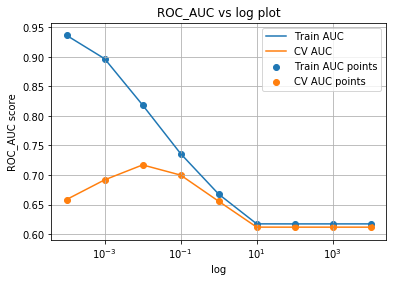

In [165]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import svm

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
SVM = SGDClassifier(loss = 'hinge', penalty = 'l2', class_weight = 'balanced')
clf = GridSearchCV(SVM, parameters, cv = 5, scoring='roc_auc',return_train_score=True)
clf.fit(Xtrain1, y_train)

train_auc = clf.cv_results_['mean_train_score']
cv_auc= clf.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log")
plt.xscale('log')
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid(True)
plt.show()

In [166]:
cv_auc

array([0.65844201, 0.69172293, 0.71705073, 0.69977688, 0.65544748,
       0.61167609, 0.61163012, 0.61163785, 0.61163786])

In [167]:
score_cv = [x for x in cv_auc]
optimal_alpha_cv = alpha[score_cv.index(max(score_cv))]
print("Maximum AUC score of cv is:" + ' ' + str(max(score_cv)))
print("Corresponding alpha value of cv is:",optimal_alpha_cv, '\n')
best_alpha_bow = optimal_alpha_cv
print(best_alpha_bow)

Maximum AUC score of cv is: 0.7170507253164411
Corresponding alpha value of cv is: 0.01 

0.01


# 12.1.4. Finding Hyperparameter 'alpha' using 'l1' regularization

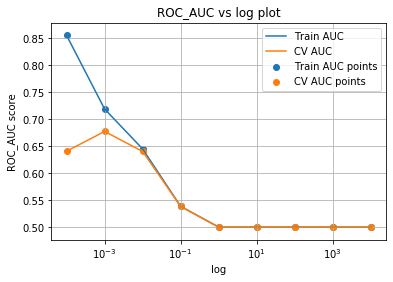

In [168]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import svm

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
SVM = SGDClassifier(loss = 'hinge', penalty = 'l1', class_weight = 'balanced')
clf = GridSearchCV(SVM, parameters, cv = 5, scoring='roc_auc',return_train_score=True)
clf.fit(Xtrain1, y_train)

train_auc = clf.cv_results_['mean_train_score']
cv_auc= clf.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log")
plt.xscale('log')
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid(True)
plt.show()

# 12.1.5. Testing the performance of the model on test data, plotting ROC Curves

In [168]:
# best_alpha_bow = 0.1 #we choose l2 regularization hyperparameter

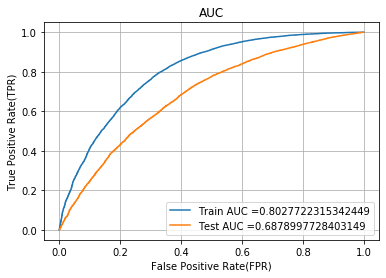

In [169]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
SVM = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = best_alpha_bow)#we choose l2 regularization hyperparameter
SVM.fit(Xtrain1 ,y_train)

y_train_pred_bow =  SVM.decision_function(Xtrain1)    
y_test_pred_bow = SVM.decision_function(Xtest1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_bow)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_bow)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [ ]:
# # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
# from sklearn.metrics import roc_curve, auc
# from sklearn.calibration import CalibratedClassifierCV


# SVM =SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = best_alpha_tfidf , max_iter = 1000)
# calibrated_svm = CalibratedClassifierCV(SVM, cv=5, method='sigmoid')
# calibrated_svm.fit(Xtrain1, y_train)
# # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# # not the predicted outputs

# y_train_pred_bow = batch_predict(calibrated_svm, Xtrain1)    
# y_test_pred_tfidf = batch_predict(calibrated_svm, Xtest1)

# train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_bow)
# test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_bow)

# plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
# plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
# plt.legend()
# plt.xlabel("TPR")
# plt.ylabel("FPR")
# plt.title("ERROR PLOTS")
# plt.grid()
# plt.show()

# 12.1.6. Building Confusion Matrix

In [172]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [173]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_bow, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_bow, best_t)))

the maximum value of tpr*(1-fpr) 0.5354053623854204 for threshold 1.048
Train confusion matrix
[[ 5120  2306]
 [ 9299 32316]]
Test confusion matrix
[[ 2961  2498]
 [ 7878 22715]]


In [174]:
confusion_matrix_train_bow = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_bow, best_t)))
confusion_matrix_test_bow = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_bow, best_t)))

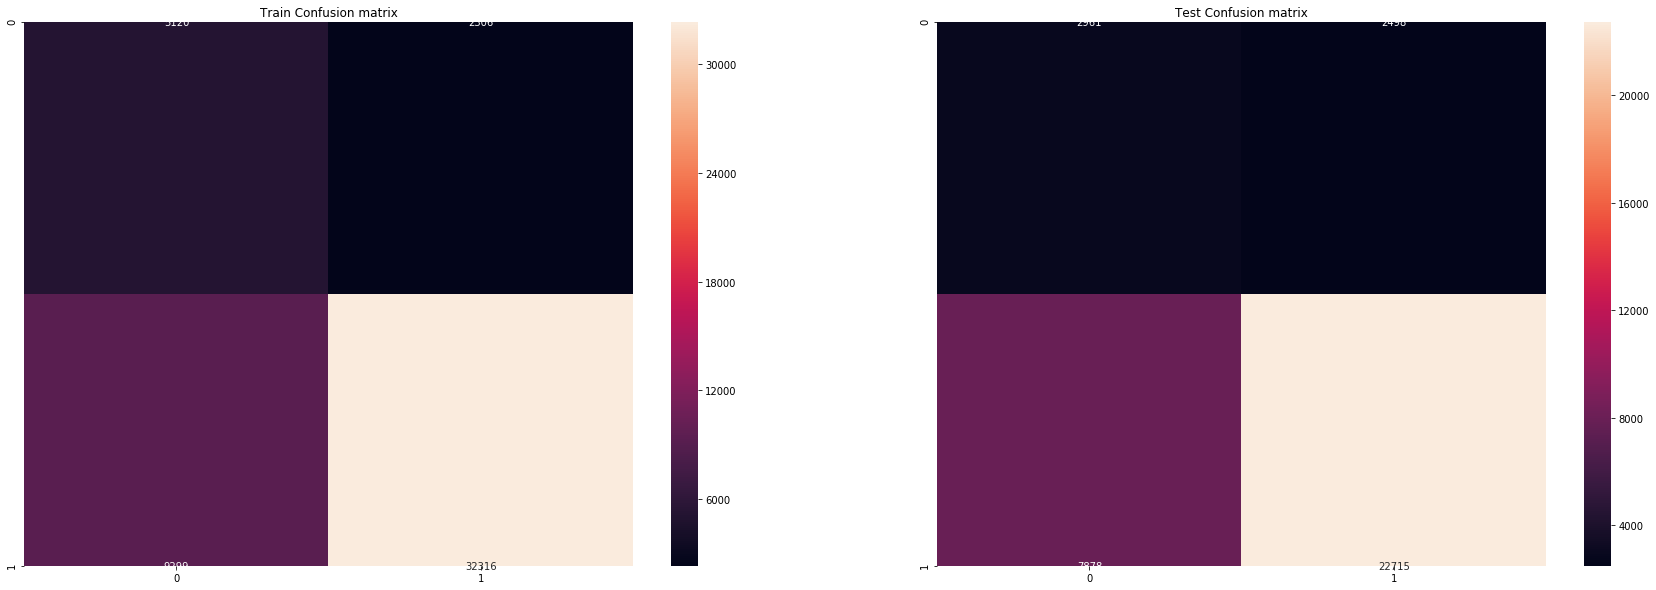

In [175]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 1.4)
sns.heatmap(confusion_matrix_train_bow,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_bow,annot = True , ax = axes[1],fmt = 'g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 12.2. Appling Support Vector Machines on TFIDF, SET 2

# 12.2.1. Finding The Best Hyperparameter "alpha" with 'l2' regularizer

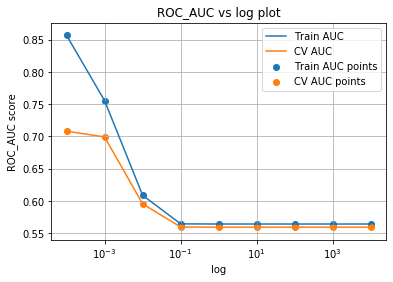

In [176]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import svm

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
SVM_tfidf = SGDClassifier(loss = 'hinge', penalty = 'l2', class_weight = 'balanced')
clf = GridSearchCV(SVM_tfidf, parameters, cv = 5, scoring='roc_auc',return_train_score=True)
clf.fit(Xtrain2, y_train)

train_auc = clf.cv_results_['mean_train_score']
cv_auc= clf.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log")
plt.xscale('log')
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid(True)
plt.show()

In [177]:
cv_auc

array([0.70808345, 0.69912552, 0.59534224, 0.55942737, 0.55924127,
       0.55924046, 0.55923993, 0.55924046, 0.55924046])

In [178]:
score_cv = [x for x in cv_auc]
optimal_alpha_cv = alpha[score_cv.index(max(score_cv))]
print("Maximum AUC score of cv is:" + ' ' + str(max(score_cv)))
print("Corresponding alpha value of cv is:",optimal_alpha_cv, '\n')
best_alpha_tfidf = optimal_alpha_cv
print(best_alpha_tfidf)

Maximum AUC score of cv is: 0.7080834505322461
Corresponding alpha value of cv is: 0.0001 

0.0001


# 12.2.2. Finding The Best Hyperparameter "alpha" using L1 regularizer

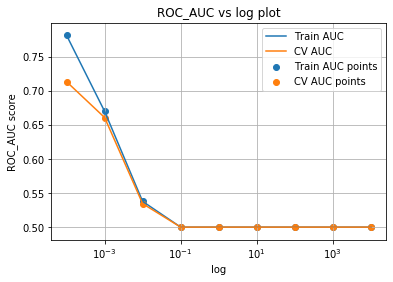

In [179]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import svm

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
SVM_tfidf = SGDClassifier(loss = 'hinge', penalty = 'l1', class_weight = 'balanced')
clf = GridSearchCV(SVM_tfidf, parameters, cv = 5, scoring='roc_auc',return_train_score=True)
clf.fit(Xtrain2, y_train)

train_auc = clf.cv_results_['mean_train_score']
cv_auc= clf.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log")
plt.xscale('log')
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid(True)
plt.show()

# 12.2.3. Testing the performance of the model on test data, plotting ROC Curves

In [186]:
# best_alpha_tfidf = 0.001

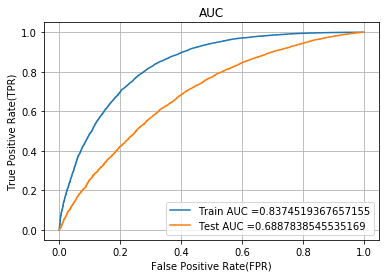

In [180]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
SVM_tfidf = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = best_alpha_tfidf) #we choose l2 regularization hyperparameter
SVM_tfidf.fit(Xtrain2 ,y_train)

y_train_pred_tfidf =  SVM_tfidf.decision_function(Xtrain2)    
y_test_pred_tfidf = SVM_tfidf.decision_function(Xtest2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidf)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidf)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

# 12.2.4. Building Confusion Matrix

In [181]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [182]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf, best_t)))

the maximum value of tpr*(1-fpr) 0.5788616289801294 for threshold 0.962
Train confusion matrix
[[ 5260  2166]
 [ 7606 34009]]
Test confusion matrix
[[ 2784  2675]
 [ 7183 23410]]


In [183]:
confusion_matrix_train_tfidf = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf, best_t)))
confusion_matrix_test_tfidf = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf, best_t)))

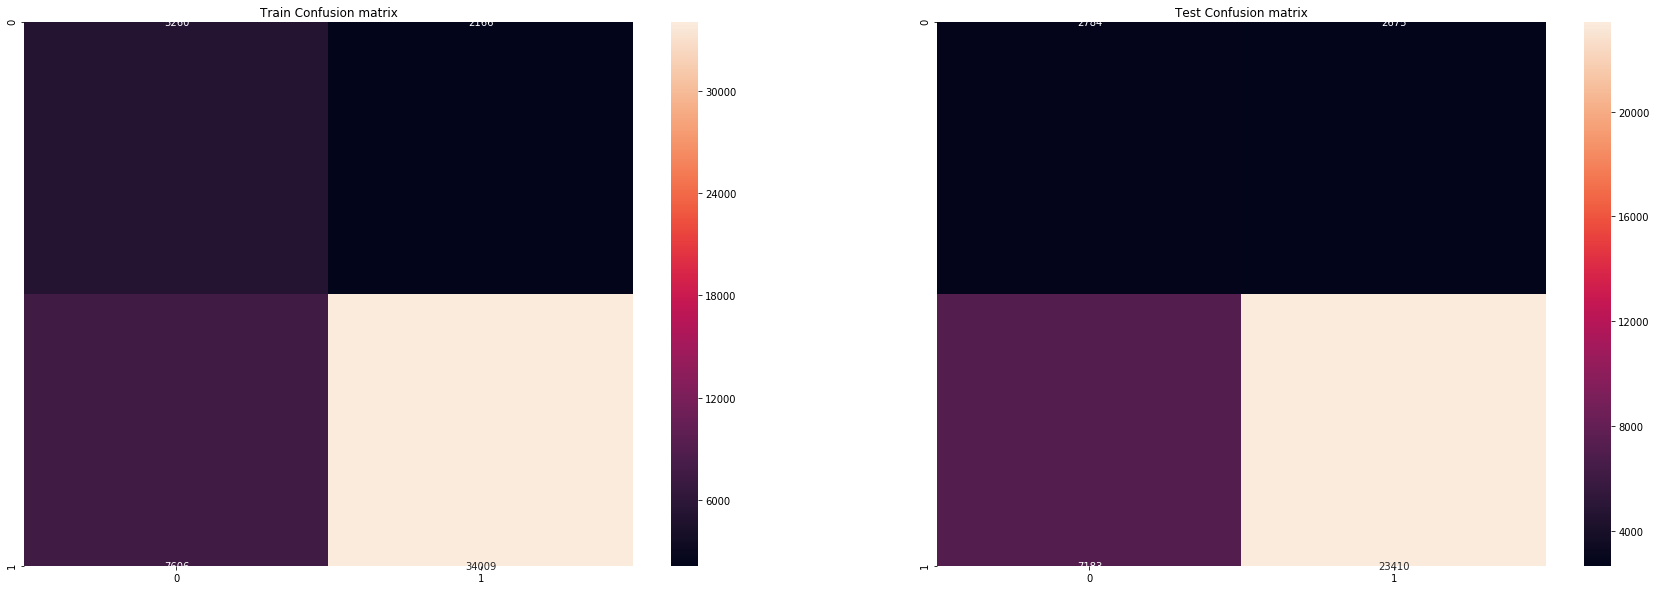

In [184]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 1.4)
sns.heatmap(confusion_matrix_train_tfidf,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_tfidf,annot = True , ax = axes[1],fmt ='g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 12.3. Appling Support Vector Machines on Average Word2Vec, SET3

# 12.3.1. Finding The Best Hyperparameter "alpha" using 'l2' regularizer

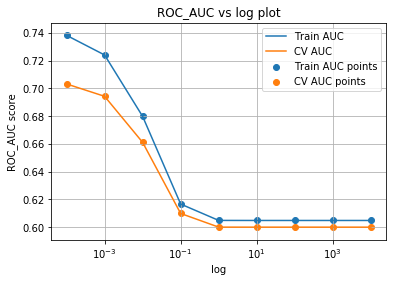

In [185]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import svm

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
SVM_avgw2v = SGDClassifier(loss = 'hinge', penalty = 'l2', class_weight = 'balanced')
clf = GridSearchCV(SVM_avgw2v, parameters, cv = 5, scoring='roc_auc',return_train_score=True)
clf.fit(Xtrain3, y_train)

train_auc = clf.cv_results_['mean_train_score']
cv_auc= clf.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log")
plt.xscale('log')
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid(True)
plt.show()

In [186]:
cv_auc

array([0.70313035, 0.69421254, 0.66103837, 0.60978999, 0.59993896,
       0.59991882, 0.59992194, 0.59992235, 0.59992177])

In [187]:
score_cv = [x for x in cv_auc]
optimal_alpha_cv = alpha[score_cv.index(max(score_cv))]
print("Maximum AUC score of cv is:" + ' ' + str(max(score_cv)))
print("Corresponding alpha value of cv is:",optimal_alpha_cv, '\n')
best_alpha_avgw2v = optimal_alpha_cv
print(best_alpha_avgw2v)

Maximum AUC score of cv is: 0.7031303486477328
Corresponding alpha value of cv is: 0.0001 

0.0001


# 12.3.2. Finding The Best Hyperparameter "alpha" using L1 regularizer

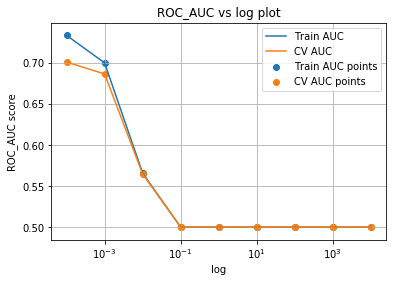

In [188]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import svm

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
SVM_avgw2v = SGDClassifier(loss = 'hinge', penalty = 'l1', class_weight = 'balanced')
clf = GridSearchCV(SVM_avgw2v, parameters, cv = 5, scoring='roc_auc',return_train_score=True)
clf.fit(Xtrain3, y_train)

train_auc = clf.cv_results_['mean_train_score']
cv_auc= clf.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log")
plt.xscale('log')
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid(True)
plt.show()

# 12.3.3. Testing the performance of the model on test data, plotting ROC Curves

In [192]:
# best_alpha_avgw2v = 0.01

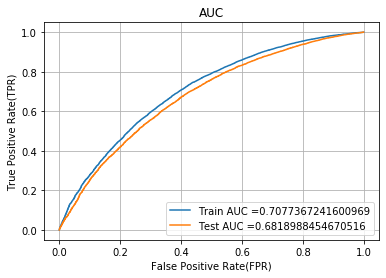

In [189]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
SVM_avgw2v = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = best_alpha_avgw2v)#we choose l2 regularization hyperparameter
SVM_avgw2v.fit(Xtrain3 ,y_train)

y_train_pred_avgw2v =  SVM_avgw2v.decision_function(Xtrain3)    
y_test_pred_avgw2v = SVM_avgw2v.decision_function(Xtest3)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_avgw2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_avgw2v)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

# 12.3.4. Building Confusion Matrix

In [190]:

# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


In [191]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_avgw2v, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_avgw2v, best_t)))

the maximum value of tpr*(1-fpr) 0.4269241092997871 for threshold 1.238
Train confusion matrix
[[ 4678  2748]
 [13412 28203]]
Test confusion matrix
[[ 3264  2195]
 [ 9986 20607]]


In [192]:
confusion_matrix_train_avgw2v = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_avgw2v, best_t)))
confusion_matrix_test_avgw2v = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_avgw2v, best_t)))

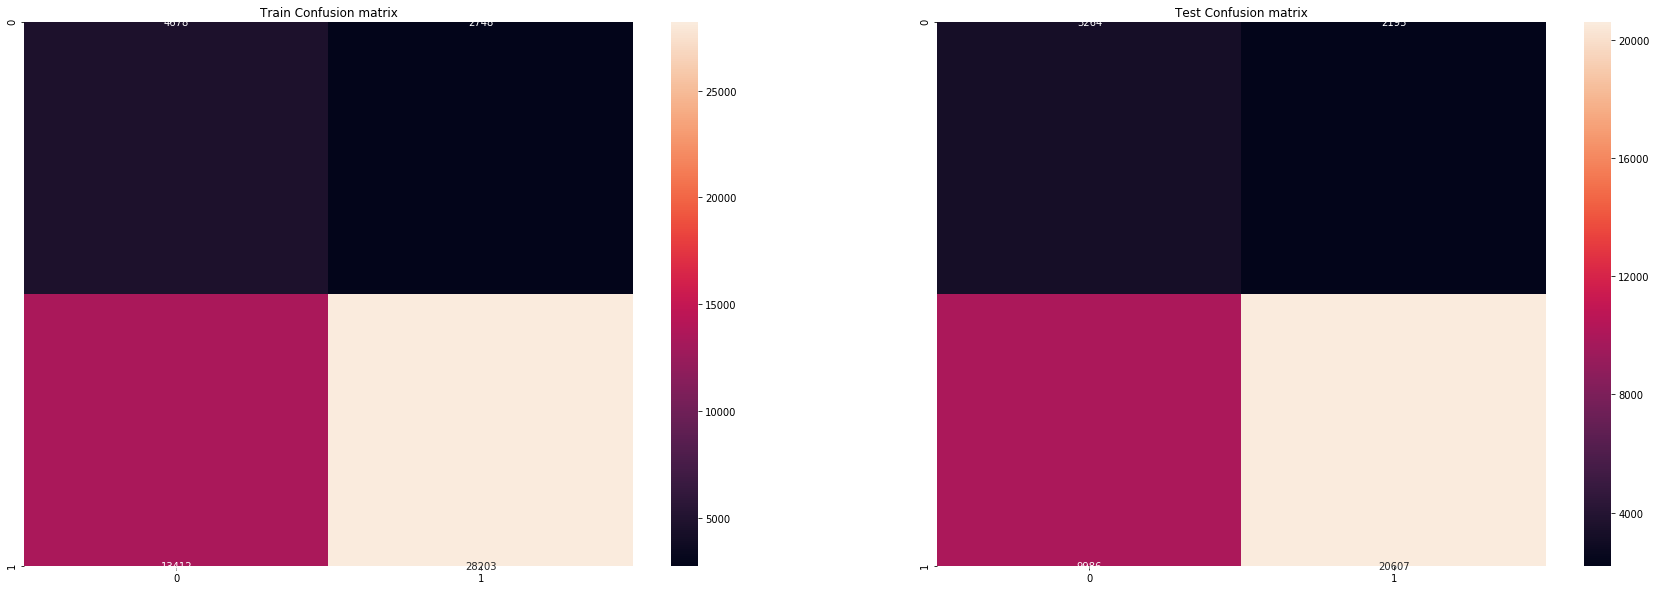

In [193]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 1.4)
sns.heatmap(confusion_matrix_train_avgw2v,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_avgw2v,annot = True , ax = axes[1],fmt = 'g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 12.4. Appling Support Vector Machines on TFIDF Word2Vec, SET4

# 12.4.1. Finding The Best Hyperparameter "alpha" with l2 regularizer

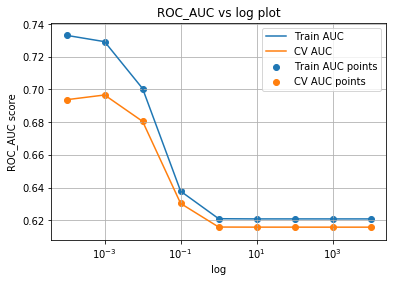

In [194]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import svm

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
SVM_tfidfw2v = SGDClassifier(loss = 'hinge', penalty = 'l2', class_weight = 'balanced')
clf = GridSearchCV(SVM_tfidfw2v, parameters, cv = 5, scoring='roc_auc',return_train_score=True)
clf.fit(Xtrain4, y_train)

train_auc = clf.cv_results_['mean_train_score']
cv_auc= clf.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log")
plt.xscale('log')
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid(True)
plt.show()

In [195]:
cv_auc

array([0.69367568, 0.69655527, 0.68042026, 0.6302879 , 0.61587482,
       0.61581933, 0.615814  , 0.6158073 , 0.61580876])

In [196]:
score_cv = [x for x in cv_auc]
optimal_alpha_cv = alpha[score_cv.index(max(score_cv))]
print("Maximum AUC score of cv is:" + ' ' + str(max(score_cv)))
print("Corresponding alpha value of cv is:",optimal_alpha_cv, '\n')
best_alpha_tfidfw2v = optimal_alpha_cv
print(best_alpha_tfidfw2v)

Maximum AUC score of cv is: 0.6965552704468035
Corresponding alpha value of cv is: 0.001 

0.001


# 12.4.2. Finding The Best Hyperparameter "alpha" using l1 regularizer

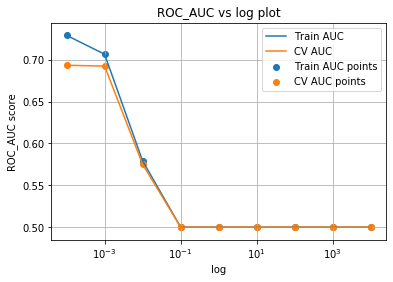

In [197]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import svm

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
SVM_tfidfw2v = SGDClassifier(loss = 'hinge', penalty = 'l1', class_weight = 'balanced')
clf = GridSearchCV(SVM_tfidfw2v, parameters, cv = 5, scoring='roc_auc',return_train_score=True)
clf.fit(Xtrain4, y_train)

train_auc = clf.cv_results_['mean_train_score']
cv_auc= clf.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log")
plt.xscale('log')
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid(True)
plt.show()

# 12.4.3. Testing the performance of the model on test data, plotting ROC Curves

In [198]:
# best_alpha_tfidfw2v = 0.01

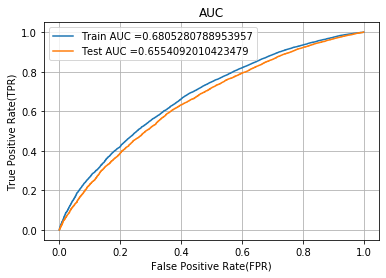

In [198]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
SVM_tfidfw2v = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = best_alpha_tfidf)#we choose l2 regularization hyperparameter
SVM_tfidfw2v.fit(Xtrain4 ,y_train)

y_train_pred_tfidfw2v =  SVM_tfidfw2v.decision_function(Xtrain4)    
y_test_pred_tfidfw2v = SVM_tfidfw2v.decision_function(Xtest4)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_tfidfw2v)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_tfidfw2v)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

# 12.4.4. Building Confusion Matrix

In [199]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [200]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidfw2v, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidfw2v, best_t)))

the maximum value of tpr*(1-fpr) 0.3982780673351412 for threshold 1.271
Train confusion matrix
[[ 4418  3008]
 [13756 27859]]
Test confusion matrix
[[ 3019  2440]
 [10098 20495]]


In [201]:
confusion_matrix_train_tfidfw2v = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidfw2v, best_t)))
confusion_matrix_test_tfidfw2v = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidfw2v, best_t)))

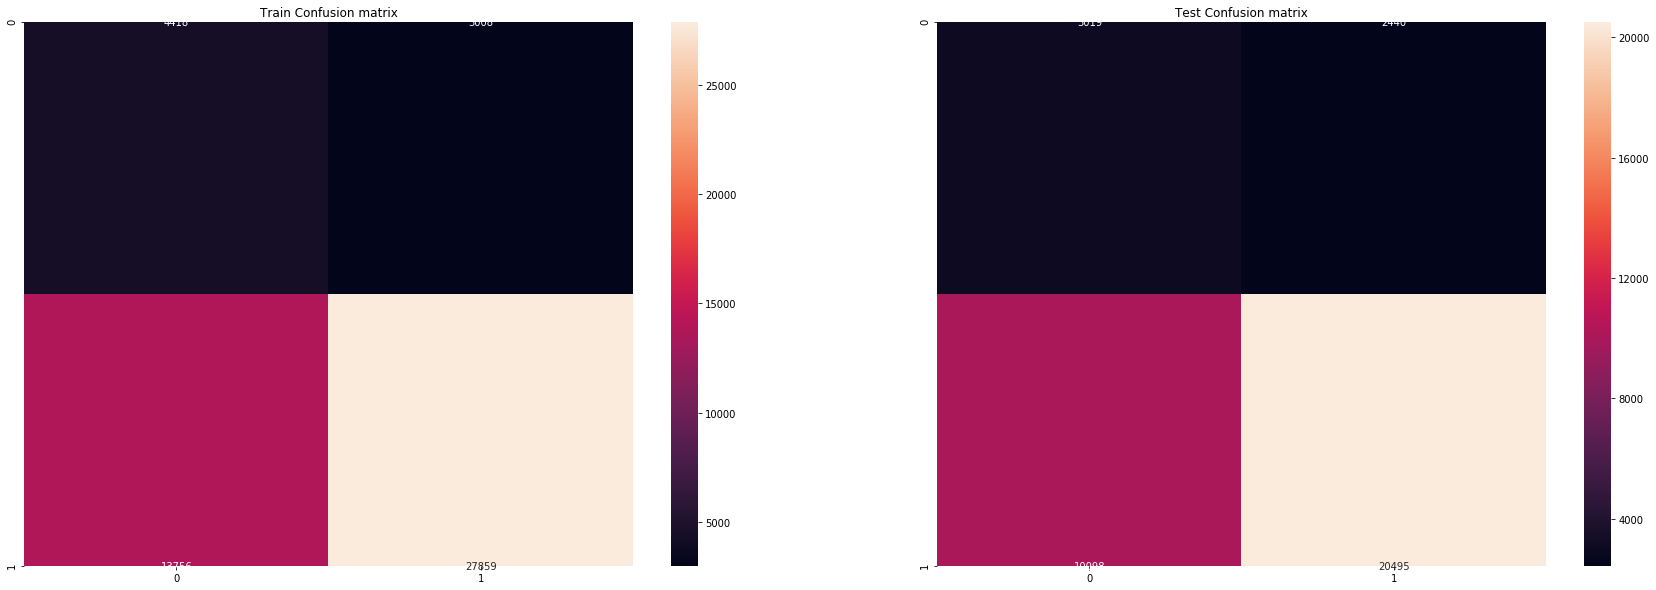

In [202]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 1.4)
sns.heatmap(confusion_matrix_train_tfidfw2v,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_tfidfw2v,annot = True , ax = axes[1],fmt ='g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 12.5. Appling Support Vector Machines on SET5

# 12.5.1. Finding The Best Hyperparameter "alpha" using l2 regularizer

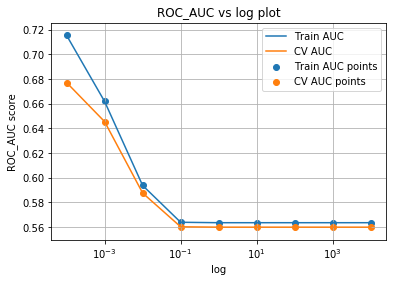

In [203]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import svm

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
SVM_set5 = SGDClassifier(loss = 'hinge', penalty = 'l2', class_weight = 'balanced')
clf = GridSearchCV(SVM_set5, parameters, cv = 5, scoring='roc_auc',return_train_score=True)
clf.fit(Xtrain5, y_train)

train_auc = clf.cv_results_['mean_train_score']
cv_auc= clf.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log")
plt.xscale('log')
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid(True)
plt.show()

In [204]:
cv_auc

array([0.67707643, 0.64543614, 0.58763918, 0.56029835, 0.56000054,
       0.56000089, 0.55999905, 0.56000122, 0.56000122])

In [208]:
score_cv = [x for x in cv_auc]
optimal_alpha_cv = alpha[score_cv.index(max(score_cv))]
print("Maximum AUC score of cv is:" + ' ' + str(max(score_cv)))
print("Corresponding alpha value of cv is:",optimal_alpha_cv, '\n')
best_alpha_set5 = optimal_alpha_cv
print(best_alpha_set5)

Maximum AUC score of cv is: 0.6770764278517651
Corresponding alpha value of cv is: 0.0001 

0.0001


# 12.5.2. Finding The Best Hyperparameter "alpha" using l1 regularizer

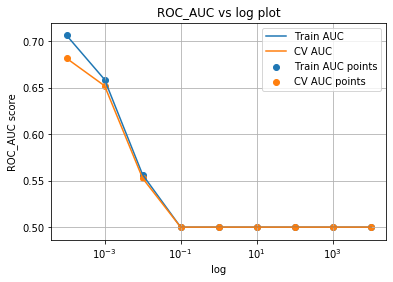

In [209]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import svm

parameters = {'alpha':[10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]}
SVM_set5 = SGDClassifier(loss = 'hinge', penalty = 'l1', class_weight = 'balanced')
clf = GridSearchCV(SVM_set5, parameters, cv = 5, scoring='roc_auc',return_train_score=True)
clf.fit(Xtrain5, y_train)

train_auc = clf.cv_results_['mean_train_score']
cv_auc= clf.cv_results_['mean_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log")
plt.xscale('log')
plt.ylabel("ROC_AUC score")
plt.title("ROC_AUC vs log plot")
plt.grid(True)
plt.show()

# 12.5.3. Testing the performance of the model on test data, plotting ROC Curves

In [243]:
# best_alpha_set5 = 0.001

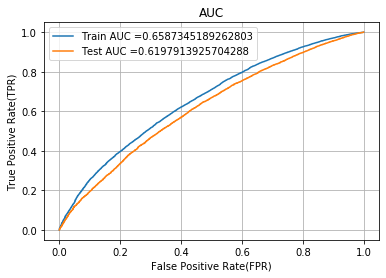

In [210]:
# https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
SVM_set5 = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = best_alpha_set5)#we choose l2 regularization hyperparameter
SVM_set5.fit(Xtrain5,y_train)

y_train_pred_set5 =  SVM_set5.decision_function(Xtrain5)    
y_test_pred_set5 = SVM_set5.decision_function(Xtest5)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_set5)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_set5)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid(True)
plt.show()

# 12.5.4. Building Confusion Matrix

In [211]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [212]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_set5, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_set5, best_t)))

the maximum value of tpr*(1-fpr) 0.3738922210214515 for threshold 1.074
Train confusion matrix
[[ 4531  2895]
 [16114 25501]]
Test confusion matrix
[[ 3116  2343]
 [12162 18431]]


In [213]:
confusion_matrix_train_set5 = pd.DataFrame(confusion_matrix(y_train, predict_with_best_t(y_train_pred_set5, best_t)))
confusion_matrix_test_set5 = pd.DataFrame(confusion_matrix(y_test, predict_with_best_t(y_test_pred_set5, best_t)))

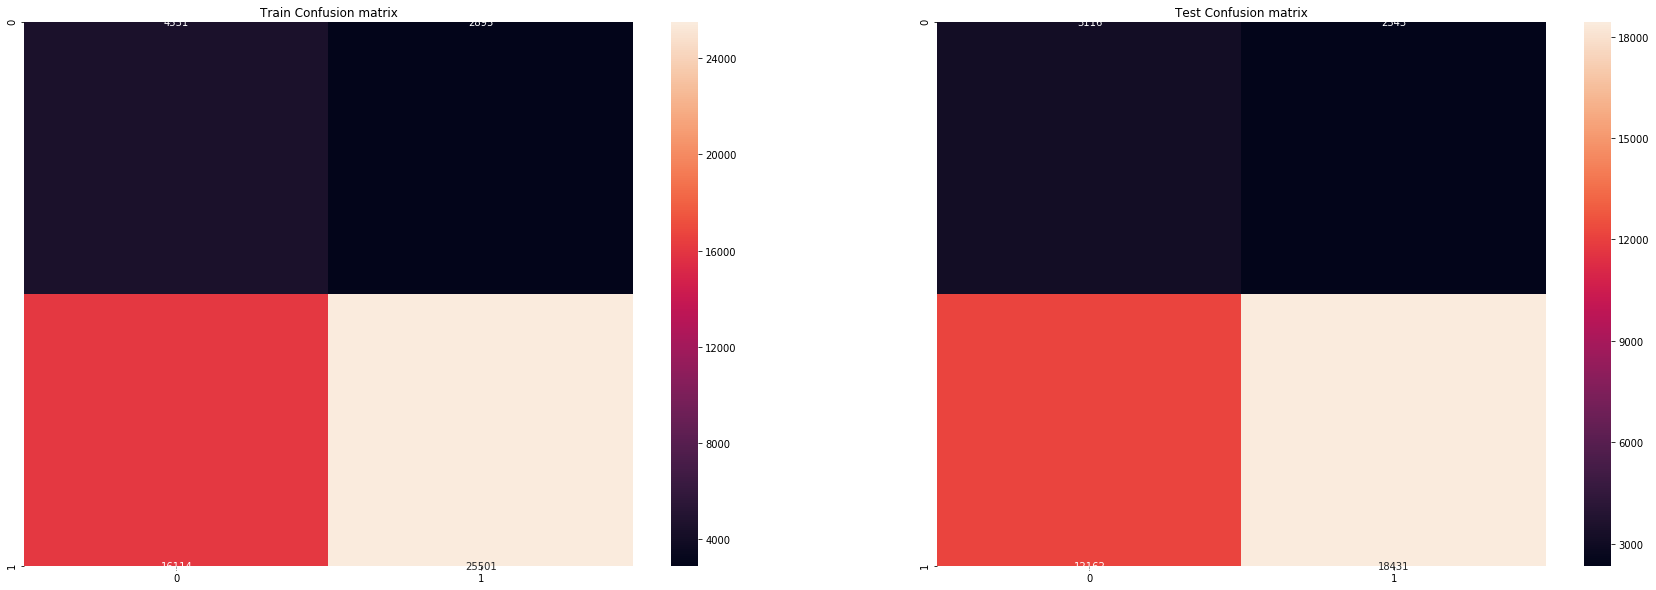

In [214]:
import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(30,10))
# sns.set(font_scale = 1.4)
sns.heatmap(confusion_matrix_train_set5,annot = True ,ax = axes[0],fmt='g')
sns.heatmap(confusion_matrix_test_set5,annot = True , ax = axes[1],fmt ='g')
axes[0].set_title('Train Confusion matrix')
axes[1].set_title('Test Confusion matrix')
plt.show()

# 13. Conclusion

In [215]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper parameter", "Train AUC","Test AUC"]

x.add_row(["BOW",   "SVM using l2 regularization", 0.01, 0.8027,0.6878])
x.add_row(["TFIDF", "SVM using l2 regularization", 0.0001, 0.8374,0.6887])
x.add_row(["AverageW2V",    "SVM using l2 regularization", 0.0001, 0.7077,0.6818])
x.add_row(["TFIDFW2V",    "SVM using l2 regularization", 0.0001, 0.6805,0.6554])
x.add_row(["SET5",   "SVM using l2 regularization", 0.0001, 0.6587,0.6197])


In [216]:
print(x)

+------------+-----------------------------+-----------------+-----------+----------+
| Vectorizer |            Model            | Hyper parameter | Train AUC | Test AUC |
+------------+-----------------------------+-----------------+-----------+----------+
|    BOW     | SVM using l2 regularization |       0.01      |   0.8027  |  0.6878  |
|   TFIDF    | SVM using l2 regularization |      0.0001     |   0.8374  |  0.6887  |
| AverageW2V | SVM using l2 regularization |      0.0001     |   0.7077  |  0.6818  |
|  TFIDFW2V  | SVM using l2 regularization |      0.0001     |   0.6805  |  0.6554  |
|    SET5    | SVM using l2 regularization |      0.0001     |   0.6587  |  0.6197  |
+------------+-----------------------------+-----------------+-----------+----------+
